# Setup

In [1]:
!source activate /home/gilbee3/anaconda3/envs/akita

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import operator as op
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'poster', style='white')
import os
import scikit_posthocs as sp

In [2]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise")

In [3]:
BASE_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome'

In [4]:
COMP_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise'

## Formatting data for analysis
The results of this are written out to files that can be loaded for any downstream analysis to make starting up faster each time. 

In [15]:
ref_list = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_reference.txt")
ref_g, ref_m, ref_s = comp_data_setup(ref_list, 'hg38_reference')

In [21]:
list_file = ref_list
base = 'hg38_reference'
comp_list=pd.read_table(list_file, sep=' ', names=['1KG','ancestor'])
if base != 'hg38_reference':
    base_df = comp_list[comp_list.ancestor==base].set_index('1KG')
else:
    base_df = comp_list.set_index('1KG')

comp_dict = {}
for row in base_df.index:
    print(row)
    ind = str(base_df.loc[row].name)
    filename = '3dcomp_%s_vs_%s.txt' % (ind,base)
    if os.path.exists('%s/reference/%s' % (COMP_PATH,filename)):
        try:
            df = pd.read_table('%s/reference/%s' % (COMP_PATH,filename))
            df = df[df.chr != 'chrX']
            comp_dict[ind] = df
        except:
            continue     

### Genome wide averages        
base_df['genome_avg_mse']=''
base_df['genome_avg_spearman']=''
for ind in comp_dict.keys():
    df = comp_dict[ind]

    avg_mse =float(np.mean(df['mse']))
    avg_spearman = float(np.mean(df['spearman']))

    base_df.genome_avg_mse.loc[ind]=avg_mse
    base_df.genome_avg_spearman.loc[ind]=avg_spearman
    

indivs = list(comp_dict.keys())
df = comp_dict[list(comp_dict.keys())[0]].set_index(['chr','windowStartPos'])
windows = df.index

base_df['temp'] = base_df.index
new = base_df.temp.str.split("_", expand = True)
base_df['super_pop'] = new[0]
base_df['sub_pop'] = new[1]
base_df['sex'] = new[2]
base_df['id'] = new[3]

genome_wide = base_df.drop(columns=['temp'])


### Window by window
mse = pd.DataFrame(index = windows, columns = indivs)
spear = pd.DataFrame(index = windows, columns = indivs)

for ind in comp_dict.keys():
    df = comp_dict[ind]
    df = df.set_index(['chr','windowStartPos'])
    mse[ind]=df['mse']
    spear[ind]=df['spearman']

mse.columns = mse.columns.str.split('_', expand=True)
spear.columns = spear.columns.str.split('_', expand=True)

AFR_ACB_female_HG01880
AFR_ACB_female_HG01883
AFR_ACB_female_HG01886
AFR_ACB_female_HG01889
AFR_ACB_female_HG01894
AFR_ACB_female_HG01896
AFR_ACB_female_HG01915
AFR_ACB_female_HG01956
AFR_ACB_female_HG01958
AFR_ACB_female_HG01985
AFR_ACB_female_HG01989
AFR_ACB_female_HG02010
AFR_ACB_female_HG02012
AFR_ACB_female_HG02052
AFR_ACB_female_HG02054
AFR_ACB_female_HG02095
AFR_ACB_female_HG02108
AFR_ACB_female_HG02111
AFR_ACB_female_HG02144
AFR_ACB_female_HG02256
AFR_ACB_female_HG02282
AFR_ACB_female_HG02308
AFR_ACB_female_HG02309
AFR_ACB_female_HG02315
AFR_ACB_female_HG02318
AFR_ACB_female_HG02322
AFR_ACB_female_HG02325
AFR_ACB_female_HG02337
AFR_ACB_female_HG02339
AFR_ACB_female_HG02419
AFR_ACB_female_HG02427
AFR_ACB_female_HG02450
AFR_ACB_female_HG02471
AFR_ACB_female_HG02476
AFR_ACB_female_HG02477
AFR_ACB_female_HG02479
AFR_ACB_female_HG02485
AFR_ACB_female_HG02497
AFR_ACB_female_HG02502
AFR_ACB_female_HG02505
AFR_ACB_female_HG02508
AFR_ACB_female_HG02511
AFR_ACB_female_HG02537
AFR_ACB_fem

In [22]:
ref_g, ref_m, ref_s = genome_wide, mse, spear

KeyError: 'SAS'

In [67]:
# ancestral_list = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_ancestral.txt")
# gagp_g, gagp_m, gagp_s = comp_data_setup(ancestral_list, 'GAGP_ancestral')

In [68]:
# ensembl_g, ensembl_m, ensembl_s = comp_data_setup(ancestral_list, 'homo_sapiens_ancestor')

In [69]:
# write_comp_dfs('gagp', gagp_g, gagp_m, gagp_s)
# write_comp_dfs('ensembl', ensembl_g, ensembl_m, ensembl_s)
# write_comp_dfs('ref', ref_g, ref_m, ref_s)

## Functions

In [6]:
def write_comp_dfs(base, g, m, s):
    g.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_genomewide_averages.csv' % base)
    m.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_window_mse.csv' % base)
    s.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_window_spearman.csv' % base)
    return

In [7]:
def comp_data_setup(list_file, base):
    comp_list=pd.read_table(list_file, sep=' ', names=['1KG','ancestor'])
    if base != 'hg38_reference':
        base_df = comp_list[comp_list.ancestor==base].set_index('1KG')
    else:
        base_df = comp_list.set_index('1KG')
    
    comp_dict = {}
    for row in base_df.index:
        ind = str(base_df.loc[row].name)
        filename = '3dcomp_%s_vs_%s.txt' % (ind,base)
        if os.path.exists('%s/%s' % (COMP_PATH,filename)):
            try:
                df = pd.read_table('%s/%s' % (COMP_PATH,filename))
                df = df[df.chr != 'chrX']
                comp_dict[ind] = df
            except:
                continue     
    
    ### Genome wide averages        
    base_df['genome_avg_mse']=''
    base_df['genome_avg_spearman']=''
    for ind in comp_dict.keys():
        df = comp_dict[ind]

        avg_mse =float(np.mean(df['mse']))
        avg_spearman = float(np.mean(df['spearman']))

        base_df.genome_avg_mse.loc[ind]=avg_mse
        base_df.genome_avg_spearman.loc[ind]=avg_spearman
        
    
    indivs = list(comp_dict.keys())
    df = comp_dict[list(comp_dict.keys())[0]].set_index(['chr','windowStartPos'])
    windows = df.index
    
    base_df['temp'] = base_df.index
    new = base_df.temp.str.split("_", expand = True)
    base_df['super_pop'] = new[0]
    base_df['sub_pop'] = new[1]
    base_df['sex'] = new[2]
    base_df['id'] = new[3]
    
    genome_wide = base_df.drop(columns=['temp'])

    
    ### Window by window
    mse = pd.DataFrame(index = windows, columns = indivs)
    spear = pd.DataFrame(index = windows, columns = indivs)

    for ind in comp_dict.keys():
        df = comp_dict[ind]
        df = df.set_index(['chr','windowStartPos'])
        mse[ind]=df['mse']
        spear[ind]=df['spearman']

    mse.columns = mse.columns.str.split('_', expand=True)
    spear.columns = spear.columns.str.split('_', expand=True)
    
    return genome_wide, mse, spear

In [8]:
def corr_plot(df):
    g = sns.lmplot(x='genome_avg_mse',y='divergence', hue='super_pop', data=df,scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
    slope, intercept, r, p, se = stats.linregress(df['genome_avg_mse'].values, df['divergence'].values)
    _ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

In [9]:
def per_window_hists(mse, spear, div):
    mse_flat = mse.to_numpy().flatten()
    spear_flat = spear.to_numpy().flatten()
    div_flat = div.to_numpy().flatten()
    
    plt.figure(figsize=(10,4))
    plt.hist(mse_flat, bins=500)
    plt.xlim(0,0.01)
    plt.xlabel('MSE (per window per individual)')

    plt.figure(figsize=(10,4))
    plt.hist(spear_flat, bins=500)
    plt.xlim(0.9,1)
    plt.xlabel('Spearman Correlation (per window per individual)')

    plt.figure(figsize=(10,4))
    plt.hist(div_flat, bins=500)
    plt.xlim(0, .1)
    plt.xlabel('3D Divergence (per window per individual)')

In [10]:
def all_indivs_genomeplot(df):
    windows = pd.DataFrame(gagp_div.mean(axis=1), columns=['mean_div'])
    
    chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8'] # did this to split the plot into a top panel and bottom, but you could just put all chroms here for 1 linear plot

    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()


    chroms = ['chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()

In [11]:
def one_chrm_pop_plot(df, chrm):
    
    afr_avg = df['AFR'].mean(axis=1)
    amr_avg = df['AMR'].mean(axis=1)
    eur_avg = df['EUR'].mean(axis=1)
    eas_avg = df['EAS'].mean(axis=1)
    sas_avg = df['SAS'].mean(axis=1)
    
    windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
    windows.columns = ['AFR','AMR','EUR','EAS','SAS']
    
    windows['AVERAGE'] = windows.mean(axis=1)
    
    df = windows.loc[chrm]
    
    fig, ax = plt.subplots(figsize=[40,10])
    sns.lineplot(y=df.AFR, 
                 x=df.index, 
                label='AFR')
    sns.lineplot(y=df.AMR, 
                 x=df.index, 
                label='AMR')
    sns.lineplot(y=df.EUR, 
                 x=df.index, 
                label='EUR')
    sns.lineplot(y=df.EAS, 
                 x=df.index, 
                label='EAS')
    sns.lineplot(y=df.SAS, 
                 x=df.index, 
                label='SAS')

In [12]:
def genome_wide_plots_stats(df, stat):
        plt.figure(figsize=(10,8))
        sns.violinplot(x='super_pop', y=stat, data=df)
        plt.figure(figsize=(30,8))
        sns.boxplot(x='sub_pop', y=stat, data=df, showfliers = False, 
                    hue='super_pop', dodge=False)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

        kruskal = stats.kruskal(df[df.super_pop=='AFR'][stat], 
                  df[df.super_pop=='AMR'][stat],
                  df[df.super_pop=='EUR'][stat],
                  df[df.super_pop=='EAS'][stat],
                  df[df.super_pop=='SAS'][stat])
        conover = sp.posthoc_conover(df, val_col=stat, group_col='super_pop', p_adjust = 'holm')
        
        print(kruskal)
        print(conover)

In [13]:
def std_genomeplot(df):
    windows = pd.DataFrame(df.std(axis=1), columns=['std_div'])
    chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8'] # did this to split the plot into a top panel and bottom, but you could just put all chroms here for 1 linear plot

    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','std_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()


    chroms = ['chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','std_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()

# Genome wide average

## Setup

In [13]:
ref = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = ref[np.isnan(ref.genome_avg_mse)].index
ref = ref.drop(index=drops)


gagp = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/gagp_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = gagp[np.isnan(gagp.genome_avg_mse)].index
gagp = gagp.drop(index=drops)


ens = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ensembl_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = ens[np.isnan(ens.genome_avg_mse)].index
ens = ens.drop(index=drops)

In [14]:
ens['divergence'] = 1-ens.genome_avg_spearman
gagp['divergence'] = 1-gagp.genome_avg_spearman
ref['divergence'] = 1-ref.genome_avg_spearman

## Correlations

In [15]:
ref

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence
1KG,,,,,,,,
AFR_ACB_female_HG01880,hg38_reference,0.000661,0.995602,AFR,ACB,female,HG01880,0.004398
AFR_ACB_female_HG01883,hg38_reference,0.000710,0.995187,AFR,ACB,female,HG01883,0.004813
AFR_ACB_female_HG01886,hg38_reference,0.000732,0.995257,AFR,ACB,female,HG01886,0.004743
AFR_ACB_female_HG01889,hg38_reference,0.000744,0.995217,AFR,ACB,female,HG01889,0.004783
AFR_ACB_female_HG01894,hg38_reference,0.000706,0.995358,AFR,ACB,female,HG01894,0.004642
...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hg38_reference,0.000591,0.996124,SAS,STU,male,HG04039,0.003876
SAS_STU_male_HG04100,hg38_reference,0.000624,0.995899,SAS,STU,male,HG04100,0.004101
SAS_STU_male_HG04107,hg38_reference,0.000617,0.996044,SAS,STU,male,HG04107,0.003956


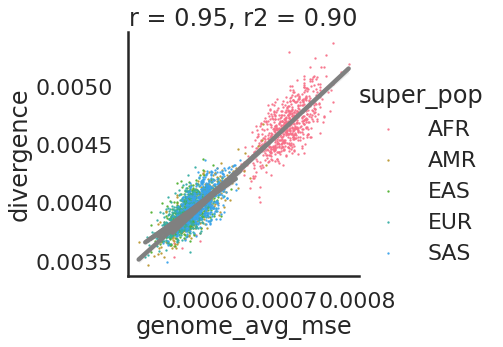

In [16]:
corr_plot(ref)

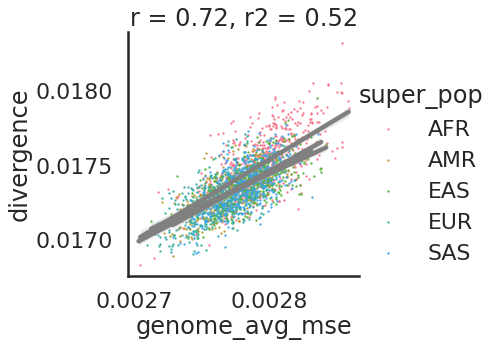

In [17]:
corr_plot(gagp)

## MSE

KruskalResult(statistic=1546.088119592947, pvalue=0.0)
               AFR            AMR           EAS           EUR            SAS
AFR   1.000000e+00  7.638617e-252  0.000000e+00  0.000000e+00  1.075796e-207
AMR  7.638617e-252   1.000000e+00  3.576371e-14  6.573246e-26   4.335911e-10
EAS   0.000000e+00   3.576371e-14  1.000000e+00  8.651565e-04   4.107039e-50
EUR   0.000000e+00   6.573246e-26  8.651565e-04  1.000000e+00   1.907739e-71
SAS  1.075796e-207   4.335911e-10  4.107039e-50  1.907739e-71   1.000000e+00


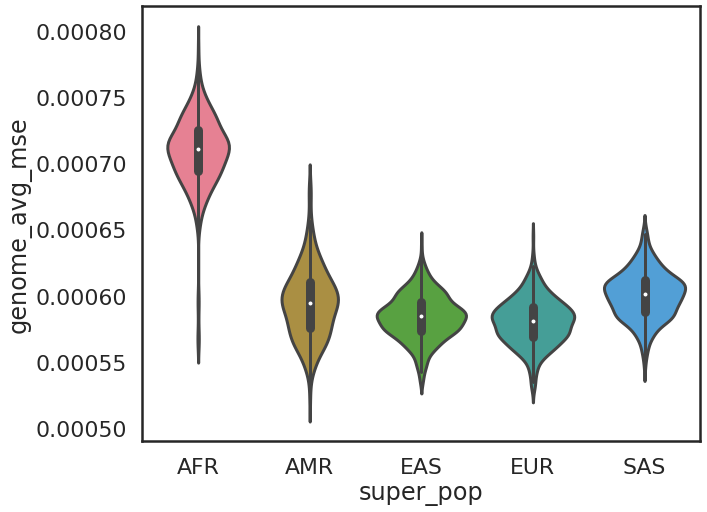

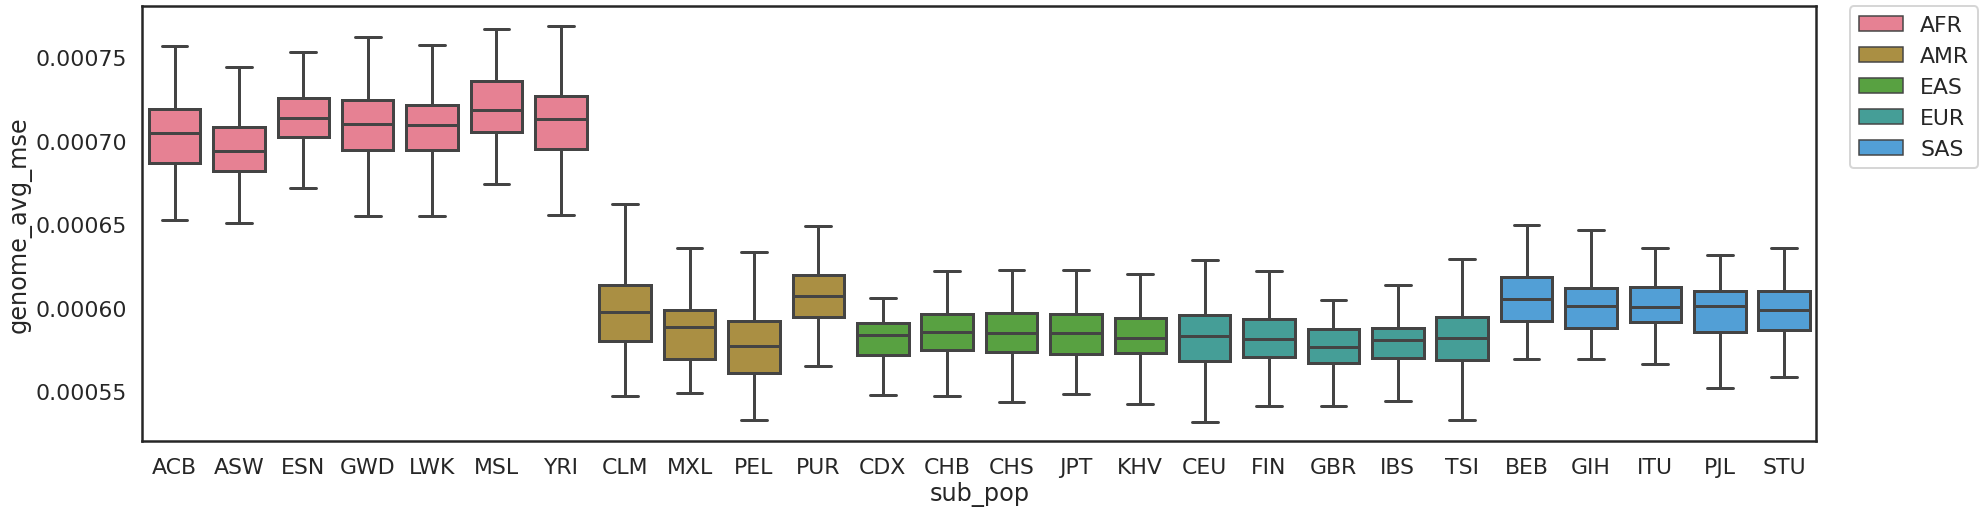

In [20]:
genome_wide_plots_stats(ref, 'genome_avg_mse')

KruskalResult(statistic=600.5632035376248, pvalue=1.1703882318531845e-128)
               AFR           AMR           EAS            EUR           SAS
AFR   1.000000e+00  8.843292e-84  3.103615e-09  1.048911e-114  5.433662e-22
AMR   8.843292e-84  1.000000e+00  1.433475e-42   2.315681e-01  1.055106e-23
EAS   3.103615e-09  1.433475e-42  1.000000e+00   6.304750e-60  3.616570e-04
EUR  1.048911e-114  2.315681e-01  6.304750e-60   1.000000e+00  1.232712e-34
SAS   5.433662e-22  1.055106e-23  3.616570e-04   1.232712e-34  1.000000e+00


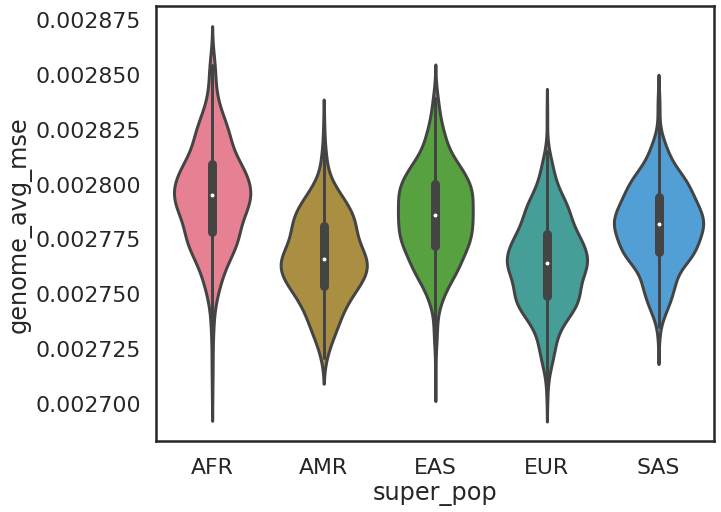

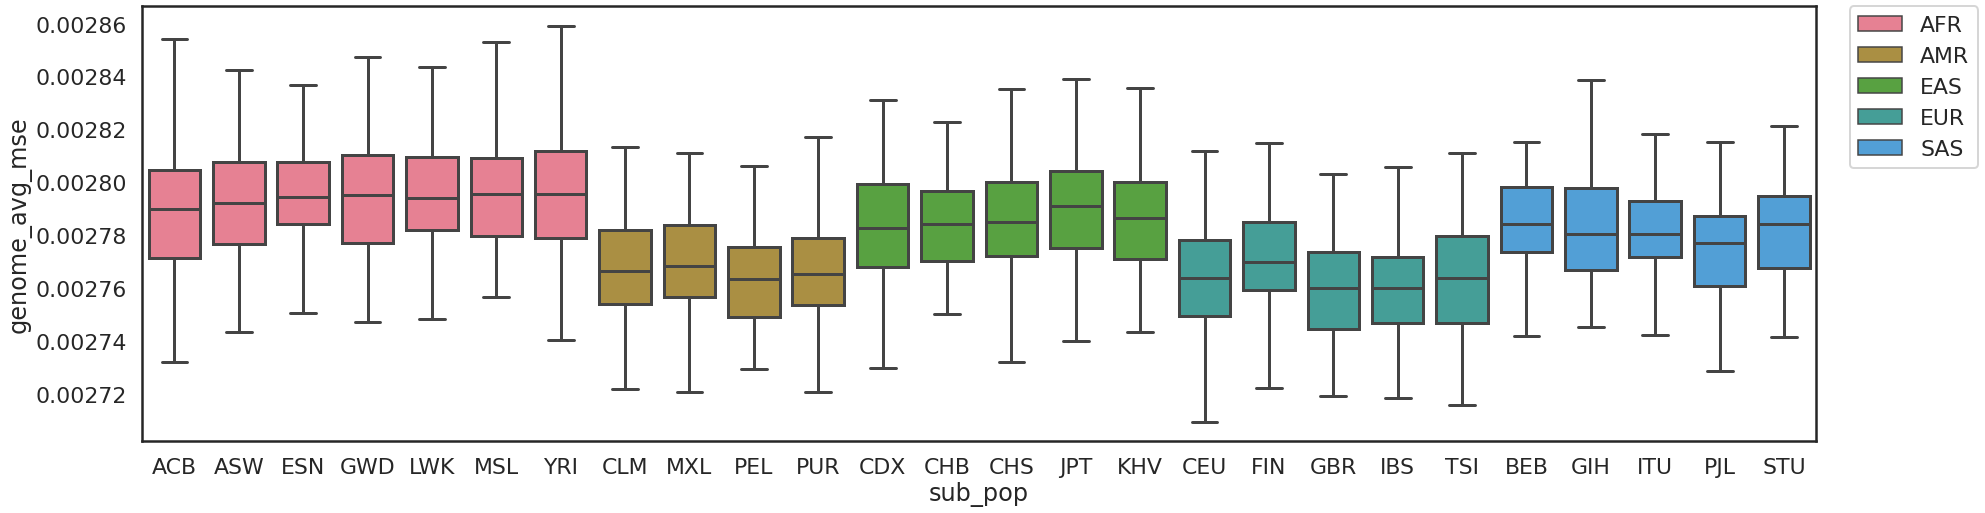

In [21]:
genome_wide_plots_stats(gagp, 'genome_avg_mse')

KruskalResult(statistic=195.40298716086818, pvalue=3.6568250972110877e-41)
              AFR           AMR           EAS           EUR           SAS
AFR  1.000000e+00  1.604676e-23  5.069647e-01  2.393741e-14  5.069647e-01
AMR  1.604676e-23  1.000000e+00  1.771213e-25  7.563455e-03  2.950661e-25
EAS  5.069647e-01  1.771213e-25  1.000000e+00  2.663870e-16  7.994802e-01
EUR  2.393741e-14  7.563455e-03  2.663870e-16  1.000000e+00  2.777595e-16
SAS  5.069647e-01  2.950661e-25  7.994802e-01  2.777595e-16  1.000000e+00


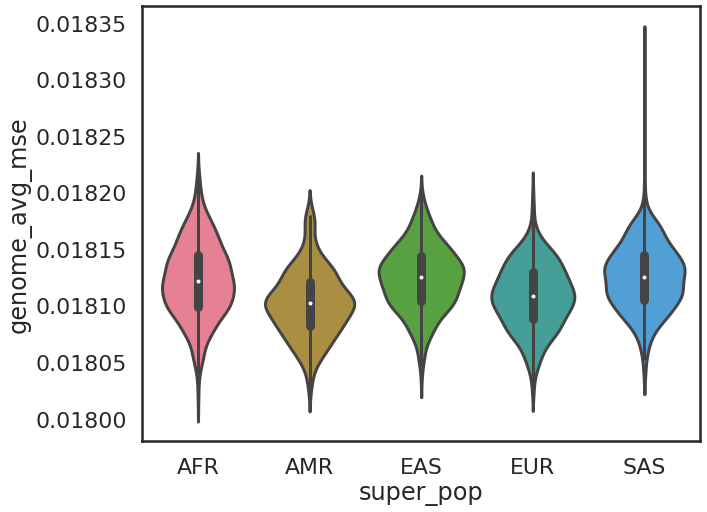

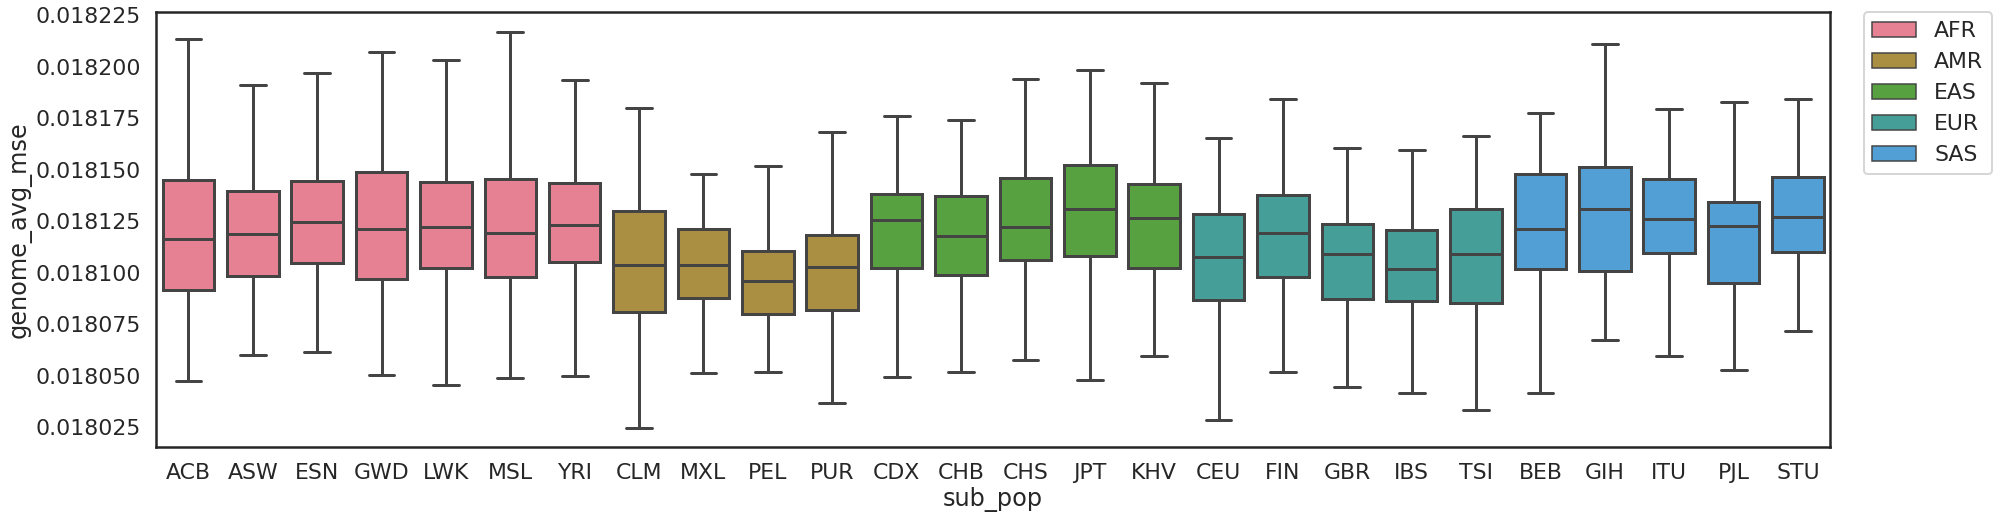

In [22]:
genome_wide_plots_stats(ens, 'genome_avg_mse')

## Spearman Correlation

KruskalResult(statistic=1433.2639273894456, pvalue=4.232474849121504e-309)
               AFR            AMR           EAS           EUR            SAS
AFR   1.000000e+00  1.011559e-247  0.000000e+00  0.000000e+00  9.593734e-213
AMR  1.011559e-247   1.000000e+00  2.447144e-04  9.180002e-08   9.180002e-08
EAS   0.000000e+00   2.447144e-04  1.000000e+00  5.187821e-02   1.525522e-23
EUR   0.000000e+00   9.180002e-08  5.187821e-02  1.000000e+00   2.774377e-32
SAS  9.593734e-213   9.180002e-08  1.525522e-23  2.774377e-32   1.000000e+00


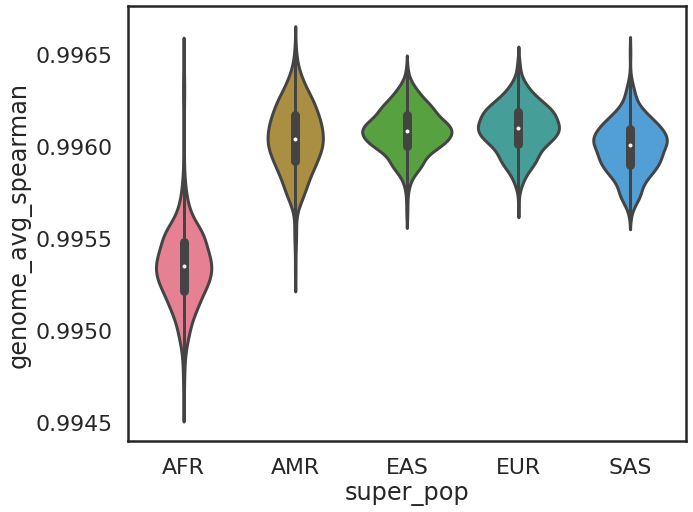

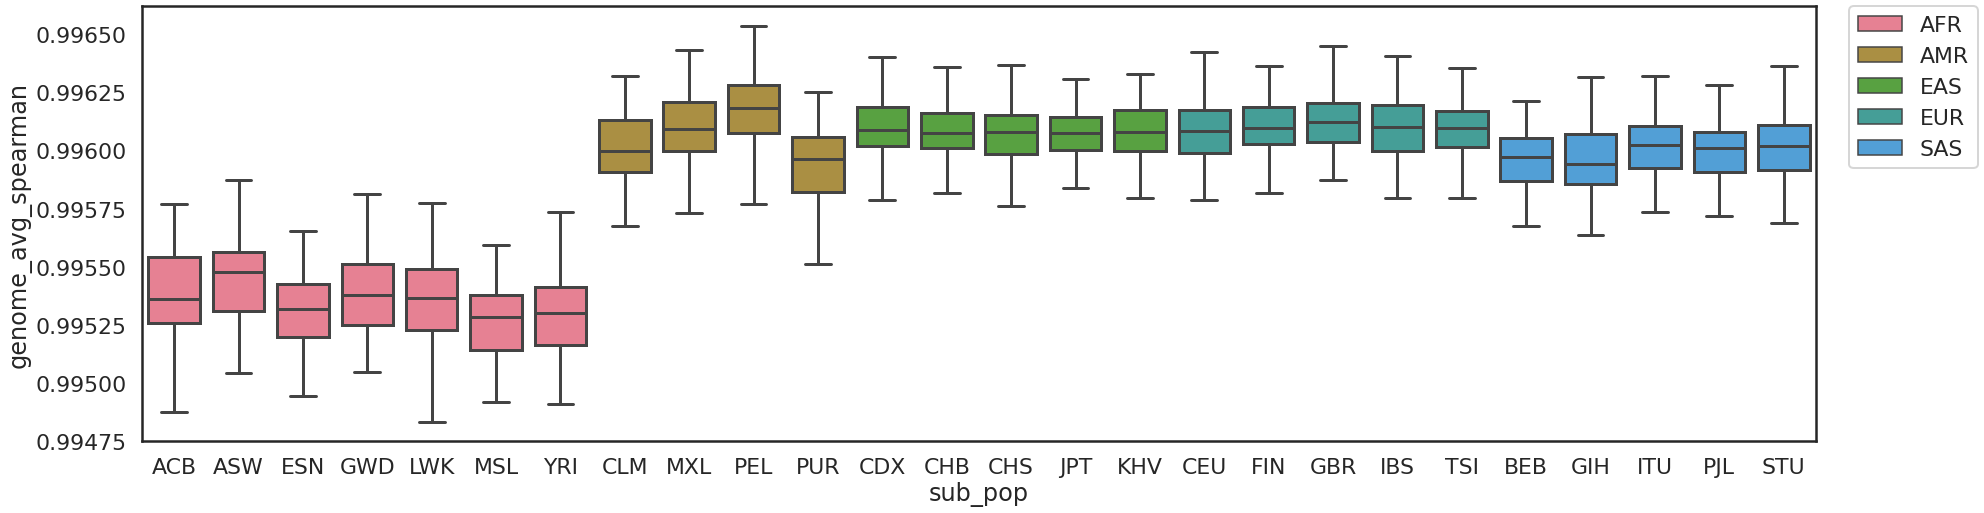

In [23]:
genome_wide_plots_stats(ref, 'genome_avg_spearman')

KruskalResult(statistic=534.159393393611, pvalue=2.73542882877376e-114)
               AFR           AMR           EAS            EUR           SAS
AFR   1.000000e+00  2.586482e-75  1.631153e-28  1.299702e-110  2.129966e-36
AMR   2.586482e-75  1.000000e+00  8.684055e-17   1.149449e-01  1.600626e-10
EAS   1.631153e-28  8.684055e-17  1.000000e+00   3.730225e-29  1.149449e-01
EUR  1.299702e-110  1.149449e-01  3.730225e-29   1.000000e+00  2.263335e-19
SAS   2.129966e-36  1.600626e-10  1.149449e-01   2.263335e-19  1.000000e+00


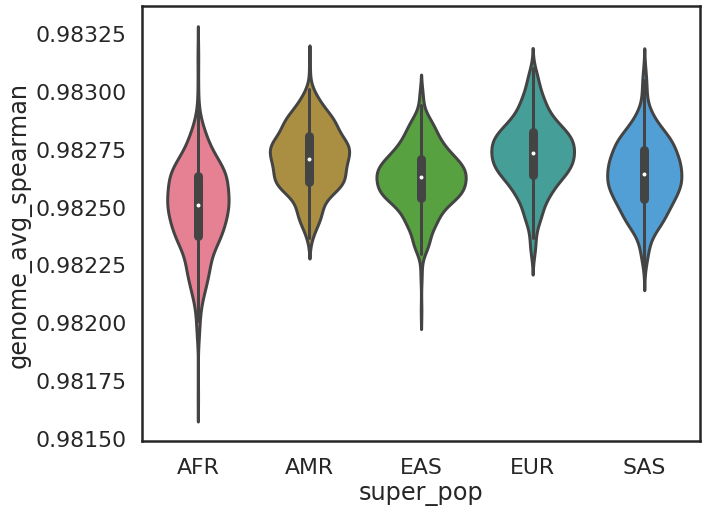

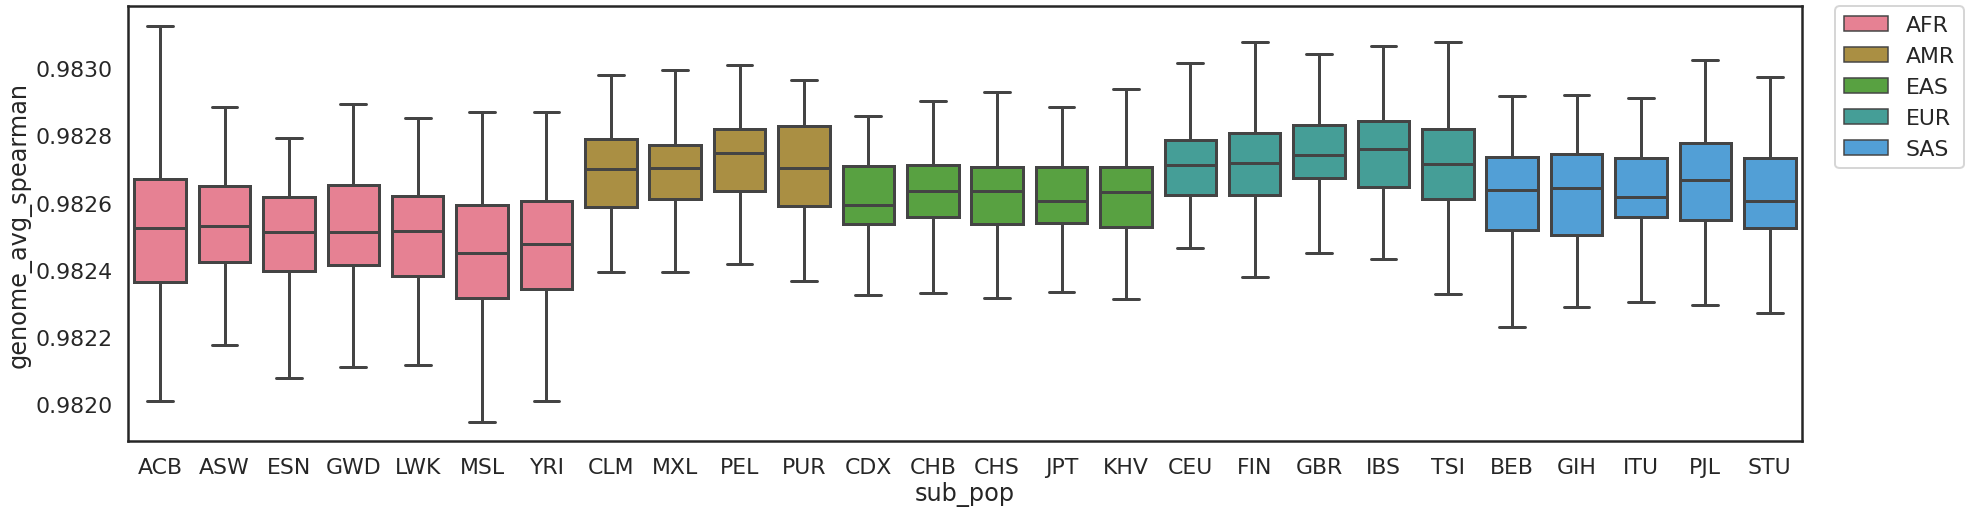

In [24]:
genome_wide_plots_stats(gagp, 'genome_avg_spearman')

KruskalResult(statistic=145.71090712159184, pvalue=1.68912236219095e-30)
              AFR           AMR           EAS           EUR           SAS
AFR  1.000000e+00  4.889417e-08  3.148001e-06  1.873512e-01  5.640190e-09
AMR  4.889417e-08  1.000000e+00  8.936026e-21  1.614585e-04  1.224249e-24
EAS  3.148001e-06  8.936026e-21  1.000000e+00  4.024037e-09  1.949580e-01
EUR  1.873512e-01  1.614585e-04  4.024037e-09  1.000000e+00  2.786896e-12
SAS  5.640190e-09  1.224249e-24  1.949580e-01  2.786896e-12  1.000000e+00


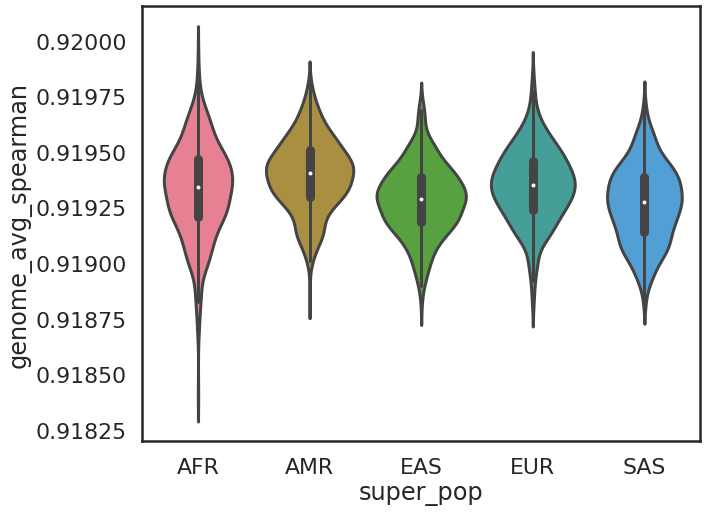

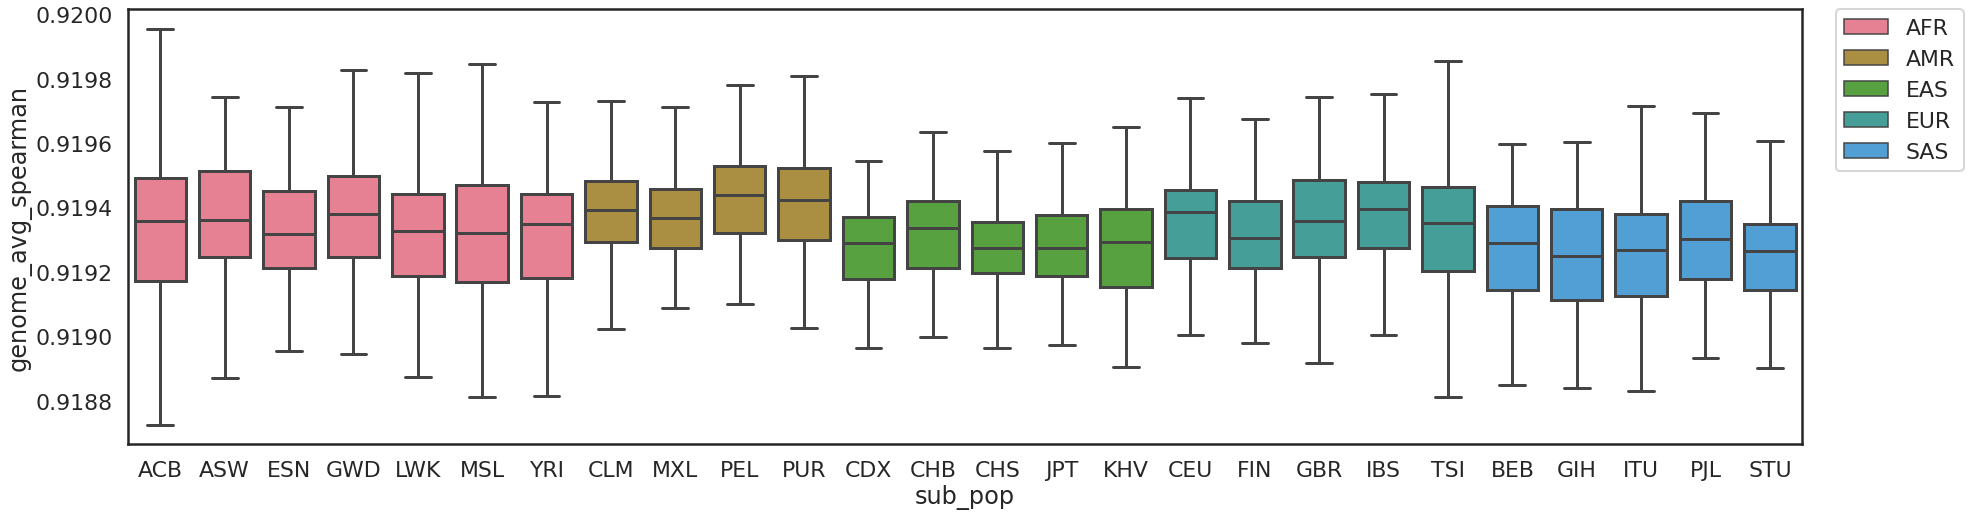

In [25]:
genome_wide_plots_stats(ens, 'genome_avg_spearman')

## Divergence

KruskalResult(statistic=534.159393393611, pvalue=2.73542882877376e-114)
               AFR           AMR           EAS            EUR           SAS
AFR   1.000000e+00  2.586482e-75  1.631153e-28  1.299702e-110  2.129966e-36
AMR   2.586482e-75  1.000000e+00  8.684055e-17   1.149449e-01  1.600626e-10
EAS   1.631153e-28  8.684055e-17  1.000000e+00   3.730225e-29  1.149449e-01
EUR  1.299702e-110  1.149449e-01  3.730225e-29   1.000000e+00  2.263335e-19
SAS   2.129966e-36  1.600626e-10  1.149449e-01   2.263335e-19  1.000000e+00


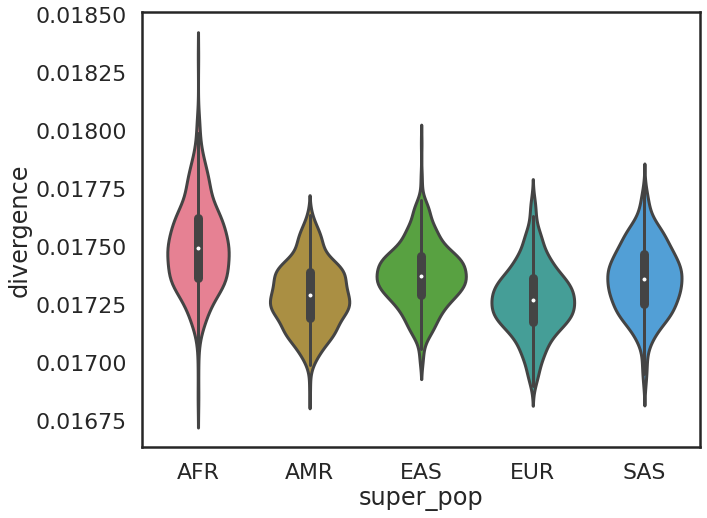

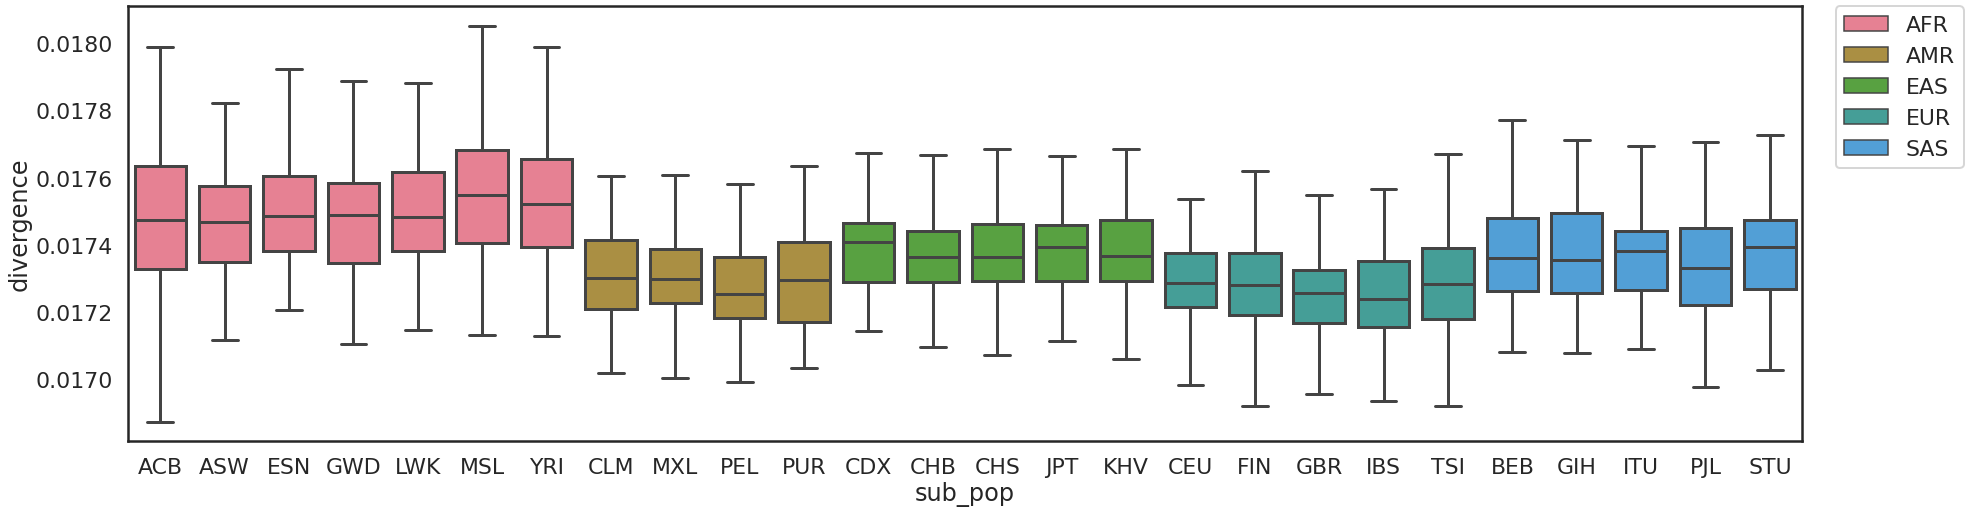

In [18]:
genome_wide_plots_stats(gagp, 'divergence')

In [108]:
sup_order = ref.groupby(by=["super_pop"])["divergence"].mean().sort_values().index
sub_order = ref.groupby(by=["sub_pop"])["divergence"].mean().sort_values().index

In [109]:
sup_mapping = pd.DataFrame({
    'super': sup_order,
})
sup_mapping = sup_mapping.reset_index().set_index('super')

sub_mapping = pd.DataFrame({
    'sub': sub_order,
})
sub_mapping = sub_mapping.reset_index().set_index('sub')

In [110]:
ref['super_rank'] = ref['super_pop'].map(sup_mapping['index'])
ref['sub_rank'] = ref['sub_pop'].map(sub_mapping['index'])

In [111]:
my_order = ref.sort_values(['super_rank','sub_rank'])


In [112]:
my_order = my_order['sub_pop'].drop_duplicates().values

In [113]:
my_order

array(['GBR', 'FIN', 'IBS', 'TSI', 'CEU', 'CHB', 'CDX', 'KHV', 'JPT',
       'CHS', 'PEL', 'MXL', 'CLM', 'PUR', 'STU', 'ITU', 'PJL', 'GIH',
       'BEB', 'ASW', 'ACB', 'GWD', 'LWK', 'ESN', 'YRI', 'MSL'],
      dtype=object)

In [114]:
eur = 'Blues'
eas = 'Greens'
sas = 'RdPu'
amr = 'Reds'
afr = 'YlOrBr_r'

In [115]:
my_pal = []

In [116]:
b = sns.color_palette(eur)
my_pal += b[1:]
b

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

In [117]:
g = sns.color_palette(eas)
my_pal+=g[1:]
g

[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),
 (0.7371472510572856, 0.895517108804306, 0.7108342945021145),
 (0.5573241061130334, 0.8164244521337947, 0.546958861976163),
 (0.3388235294117647, 0.7117262591311034, 0.40584390618992694),
 (0.17139561707035755, 0.581514801999231, 0.2979008073817762),
 (0.017762399077277974, 0.44267589388696654, 0.18523644752018453)]

In [118]:
p = sns.color_palette(sas)
my_pal+=p[1:-1]
p

[(0.9916493656286044, 0.8647289504036909, 0.8519492502883507),
 (0.9859592464436755, 0.7293041138023837, 0.7404229142637447),
 (0.9754555940023067, 0.5330257593233372, 0.6768935024990388),
 (0.9094502114571319, 0.2894886582083814, 0.6086120722798923),
 (0.735840061514802, 0.06196078431372548, 0.5225682429834679),
 (0.5048212226066897, 0.00392156862745098, 0.47021914648212226)]

In [119]:
r = sns.color_palette(amr)
my_pal+= r[1:]
r

[(0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.6663437139561708, 0.06339100346020761, 0.08641291810841982)]

In [120]:
o = sns.color_palette(afr,7)
my_pal+=o
o

[(0.6007843137254901, 0.20429065743944635, 0.015655517108804307),
 (0.8009842368319877, 0.29914648212226064, 0.00839677047289504),
 (0.9263206459054211, 0.44110726643598613, 0.0794002306805075),
 (0.996078431372549, 0.602645136485967, 0.16312187620146099),
 (0.996078431372549, 0.7710111495578624, 0.314878892733564),
 (0.9961707035755479, 0.8920415224913494, 0.5725951557093425),
 (1.0, 0.9694886582083814, 0.7416685890042292)]

In [121]:
my_pal

[(0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.7371472510572856, 0.895517108804306, 0.7108342945021145),
 (0.5573241061130334, 0.8164244521337947, 0.546958861976163),
 (0.3388235294117647, 0.7117262591311034, 0.40584390618992694),
 (0.17139561707035755, 0.581514801999231, 0.2979008073817762),
 (0.017762399077277974, 0.44267589388696654, 0.18523644752018453),
 (0.9859592464436755, 0.7293041138023837, 0.7404229142637447),
 (0.9754555940023067, 0.5330257593233372, 0.6768935024990388),
 (0.9094502114571319, 0.2894886582083814, 0.6086120722798923),
 (0.735840061514802, 0.06196078431372548, 0.5225682429834679),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123

In [122]:
my_order

array(['GBR', 'FIN', 'IBS', 'TSI', 'CEU', 'CHB', 'CDX', 'KHV', 'JPT',
       'CHS', 'PEL', 'MXL', 'CLM', 'PUR', 'STU', 'ITU', 'PJL', 'GIH',
       'BEB', 'ASW', 'ACB', 'GWD', 'LWK', 'ESN', 'YRI', 'MSL'],
      dtype=object)

In [123]:
len(my_order)

26

In [124]:
len(my_pal)

26

No handles with labels found to put in legend.


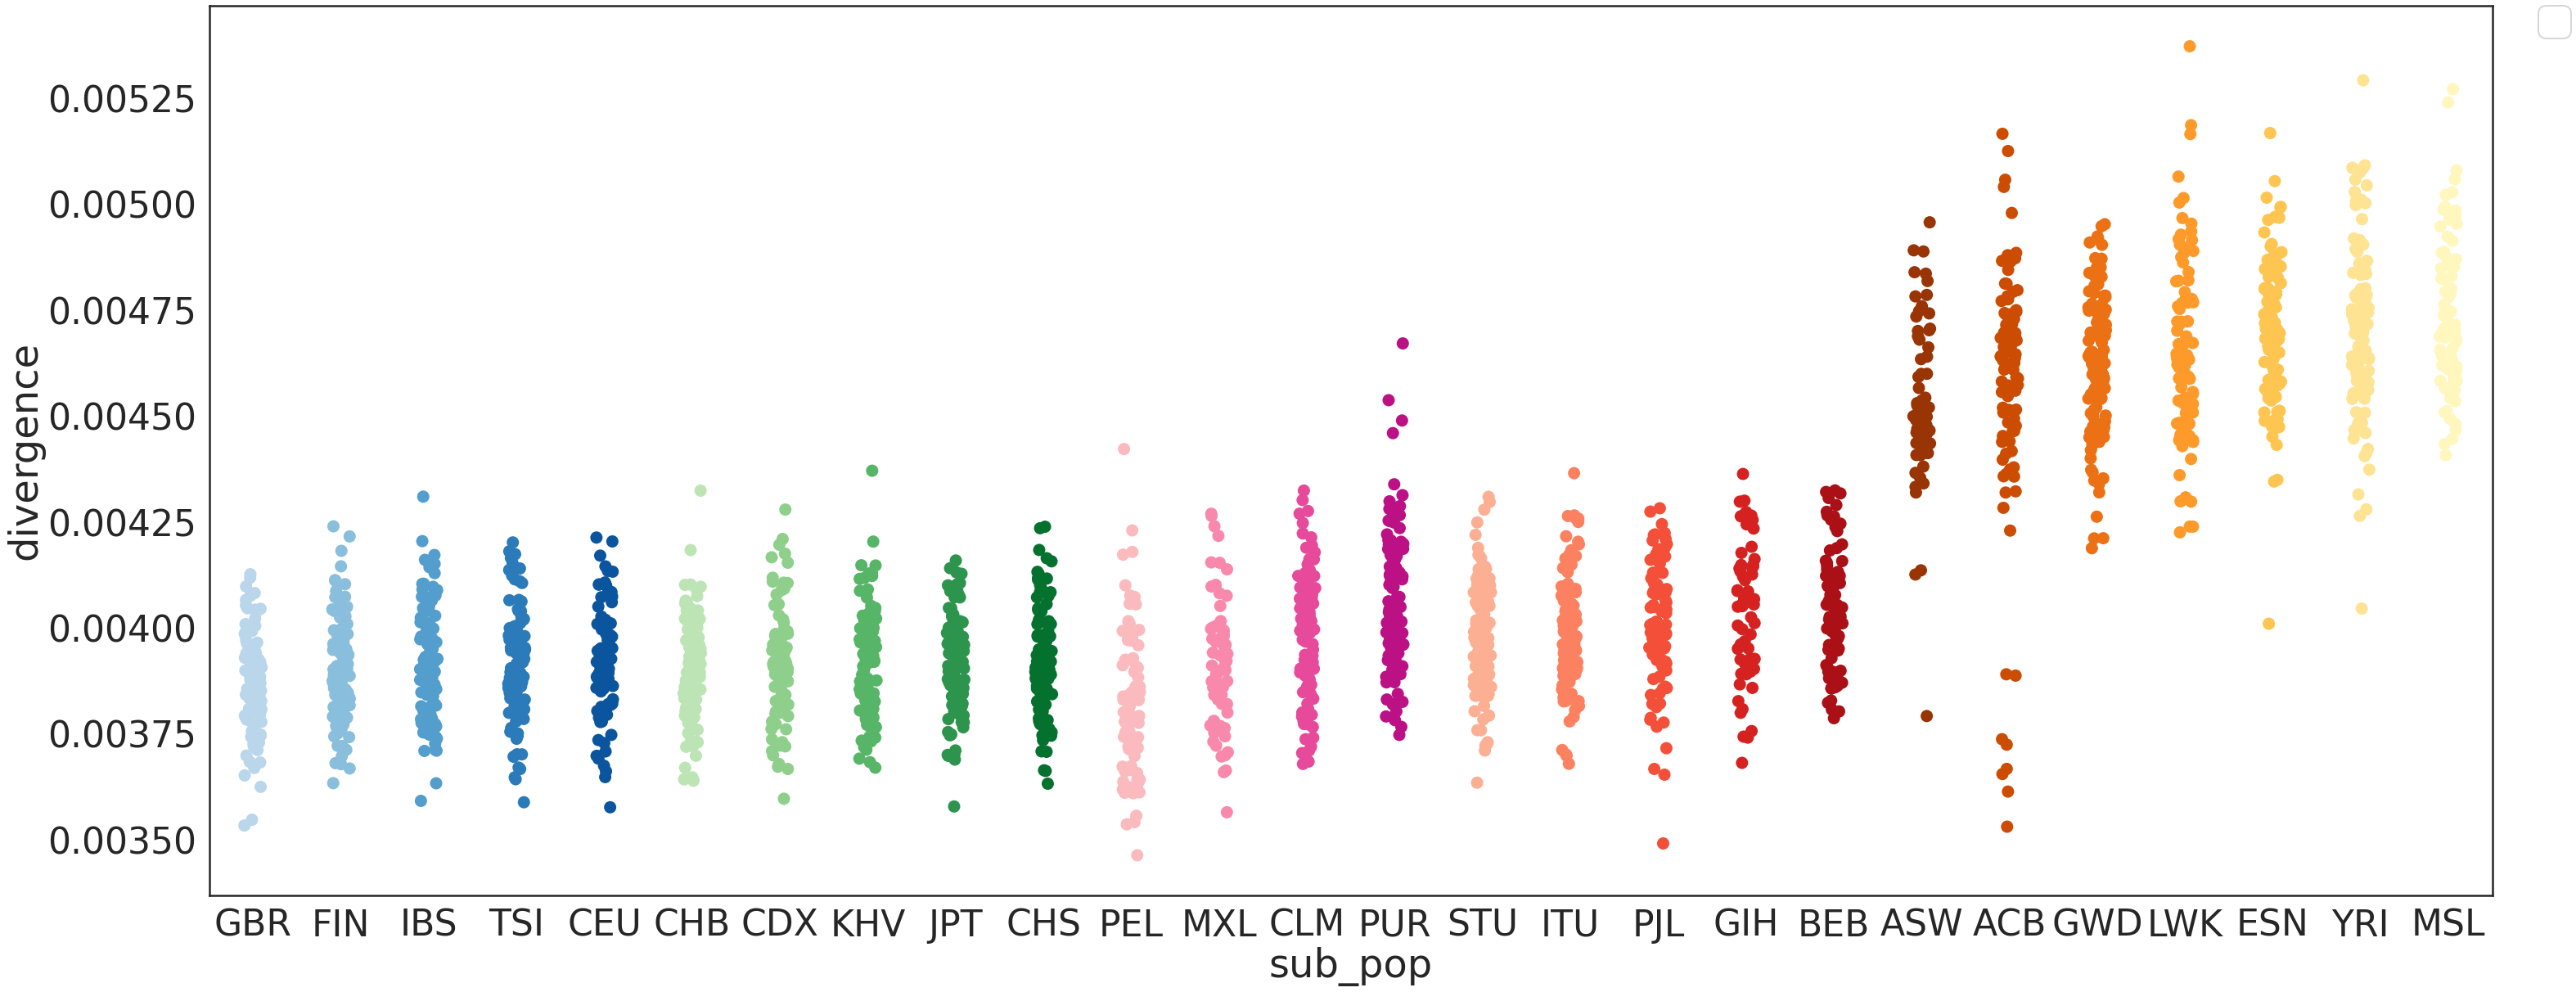

In [125]:
sns.set(font_scale=2, context = 'poster', style='white')
plt.figure(figsize=(50,20))
sns.stripplot(x='sub_pop', y='divergence', data=ref, dodge=False,s=15, 
              palette=my_pal, 
              order = my_order)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=50)

In [19]:
gagp

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence
1KG,,,,,,,,
AFR_ACB_female_HG01880,GAGP_ancestral,0.002758,0.982713,AFR,ACB,female,HG01880,0.017287
AFR_ACB_female_HG01883,GAGP_ancestral,0.002794,0.982436,AFR,ACB,female,HG01883,0.017564
AFR_ACB_female_HG01886,GAGP_ancestral,0.002780,0.982550,AFR,ACB,female,HG01886,0.017450
AFR_ACB_female_HG01889,GAGP_ancestral,0.002808,0.982364,AFR,ACB,female,HG01889,0.017636
AFR_ACB_female_HG01894,GAGP_ancestral,0.002787,0.982685,AFR,ACB,female,HG01894,0.017315
...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,GAGP_ancestral,0.002752,0.982695,SAS,STU,male,HG04039,0.017305
SAS_STU_male_HG04100,GAGP_ancestral,0.002772,0.982732,SAS,STU,male,HG04100,0.017268
SAS_STU_male_HG04107,GAGP_ancestral,0.002789,0.982663,SAS,STU,male,HG04107,0.017337


KruskalResult(statistic=534.159393393611, pvalue=2.73542882877376e-114)
               AFR           AMR           EAS            EUR           SAS
AFR   1.000000e+00  2.586482e-75  1.631153e-28  1.299702e-110  2.129966e-36
AMR   2.586482e-75  1.000000e+00  8.684055e-17   1.149449e-01  1.600626e-10
EAS   1.631153e-28  8.684055e-17  1.000000e+00   3.730225e-29  1.149449e-01
EUR  1.299702e-110  1.149449e-01  3.730225e-29   1.000000e+00  2.263335e-19
SAS   2.129966e-36  1.600626e-10  1.149449e-01   2.263335e-19  1.000000e+00


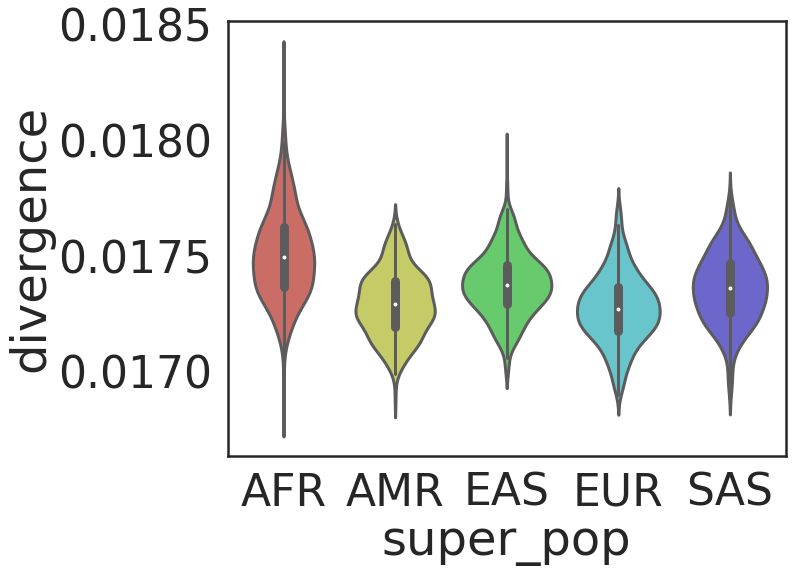

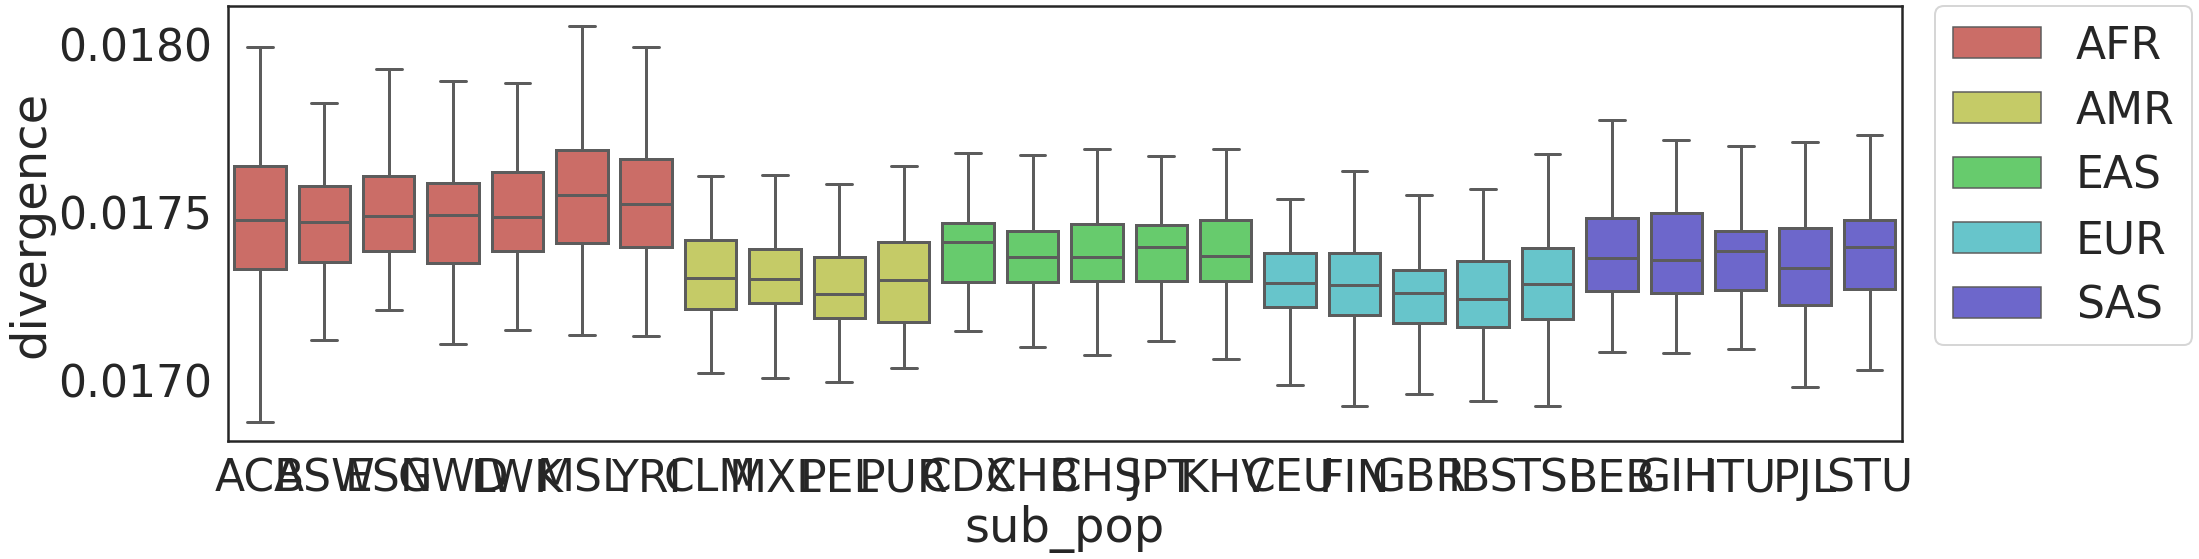

In [142]:
genome_wide_plots_stats(gagp, 'divergence')

# Window wise metrics

### Distributions

In [27]:
ref_mse = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_window_mse.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ref_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_window_spearman.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ref_div = 1-ref_spear

gagp_mse = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/gagp_window_mse.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
gagp_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/gagp_window_spearman.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
gagp_div = 1-gagp_spear

ens_mse = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ensembl_window_mse.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ens_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ensembl_window_spearman.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ens_div = 1-ens_spear

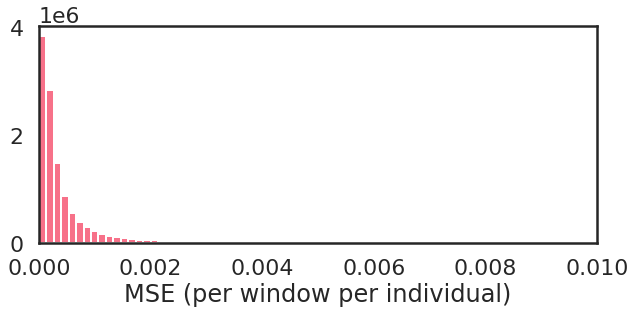

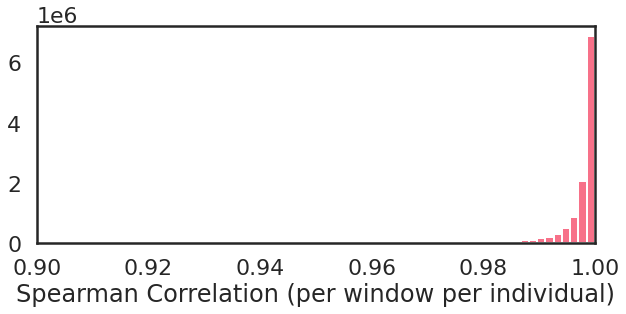

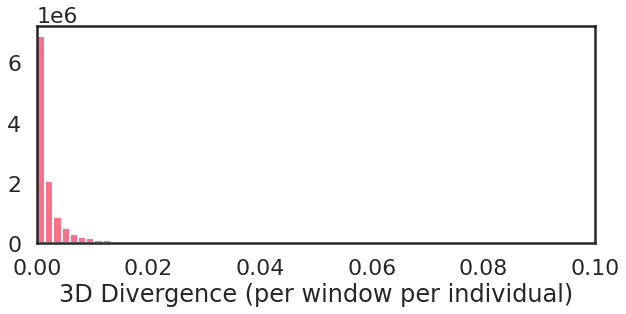

In [28]:
per_window_hists(ref_mse, ref_spear, ref_div)

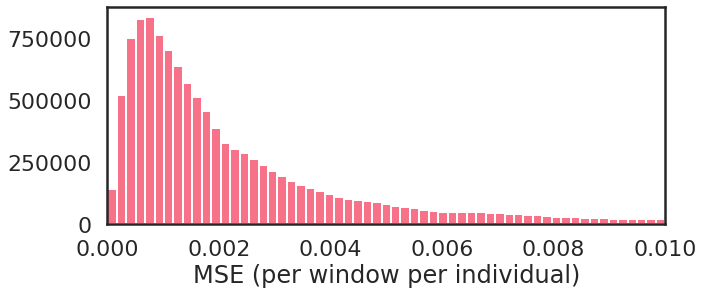

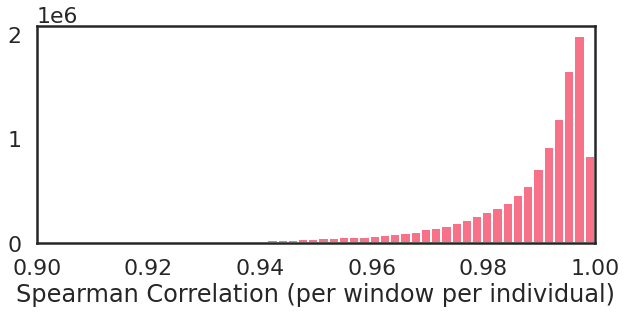

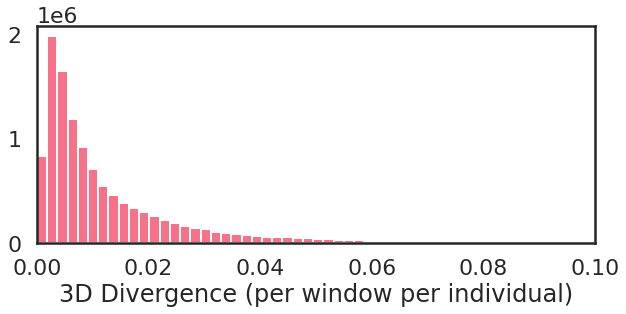

In [29]:
per_window_hists(gagp_mse, gagp_spear, gagp_div)

Plot the scatter of reference vs gagp, what is off the diagonal? This might signal things that are diverged on different time scales

## MSE

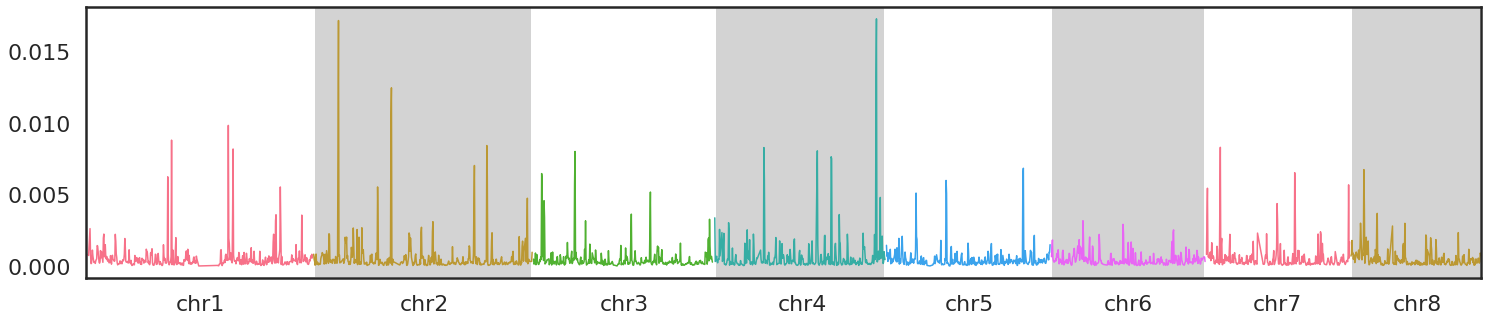

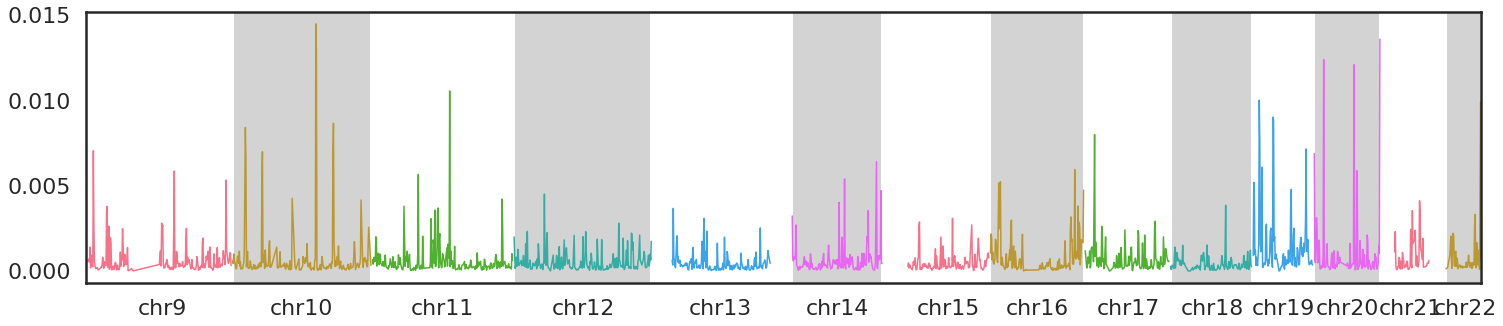

In [47]:
all_indivs_genomeplot(ref_mse)

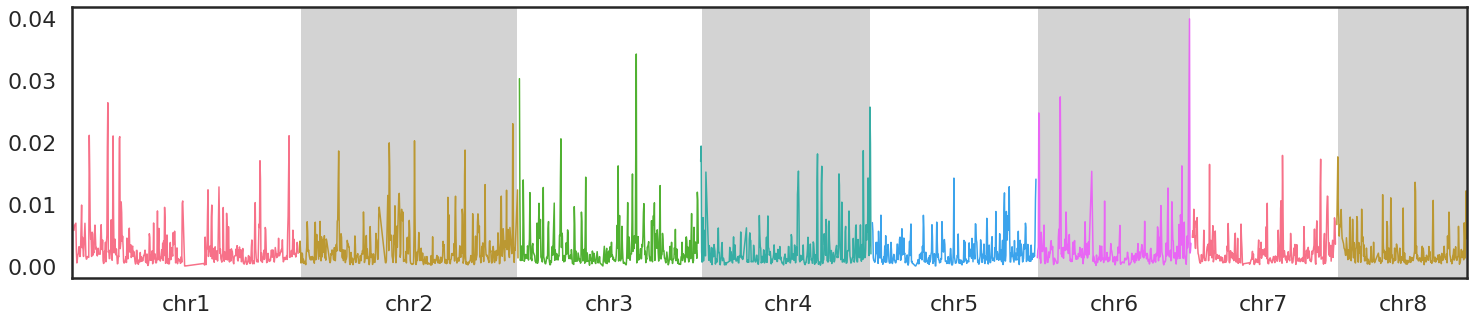

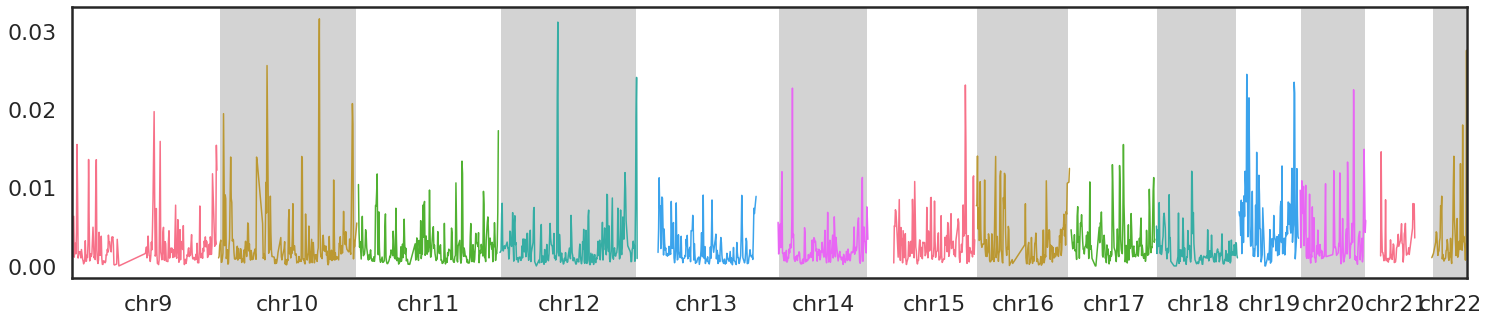

In [48]:
all_indivs_genomeplot(gagp_mse)

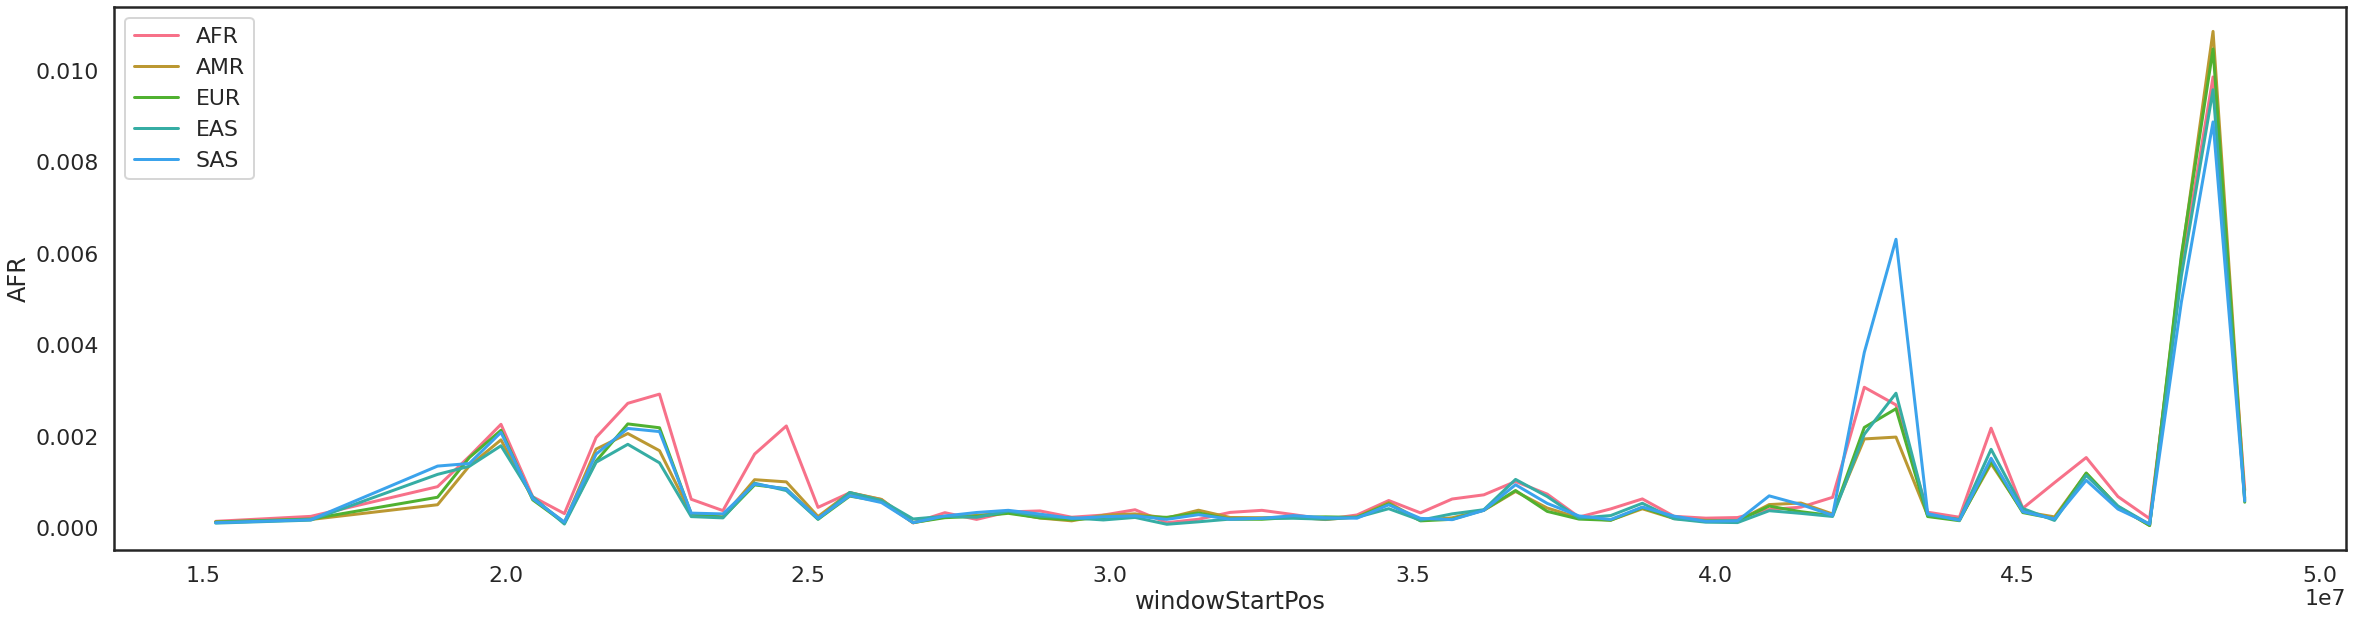

In [50]:
one_chrm_pop_plot(ref_mse, 'chr22')

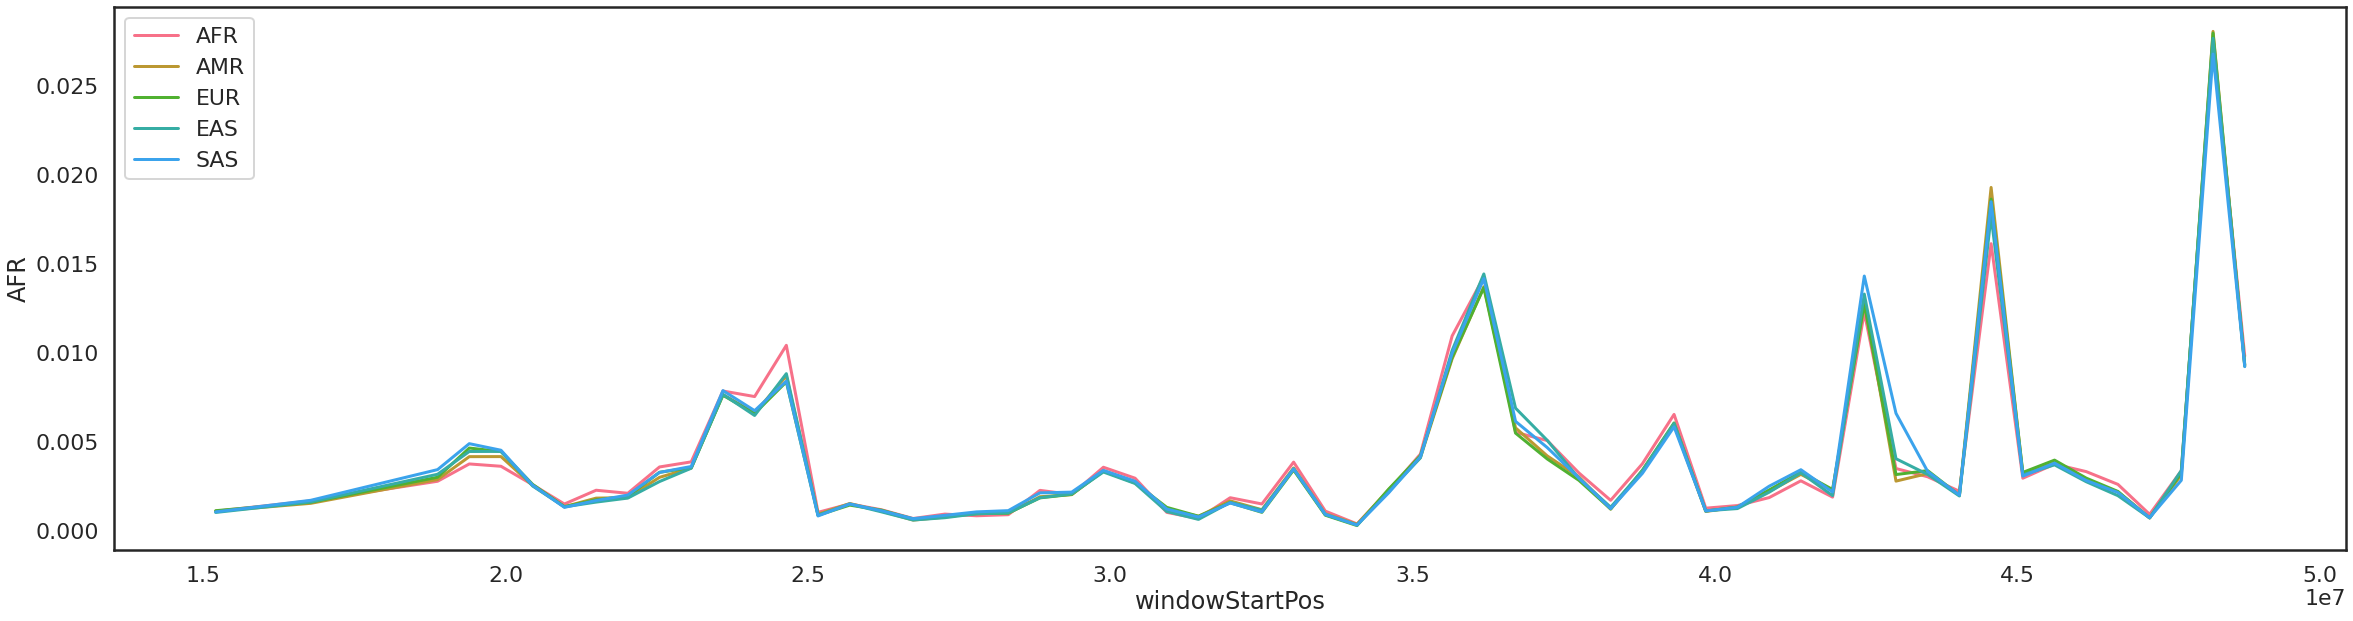

In [51]:
one_chrm_pop_plot(gagp_mse, 'chr22')

## Spearman

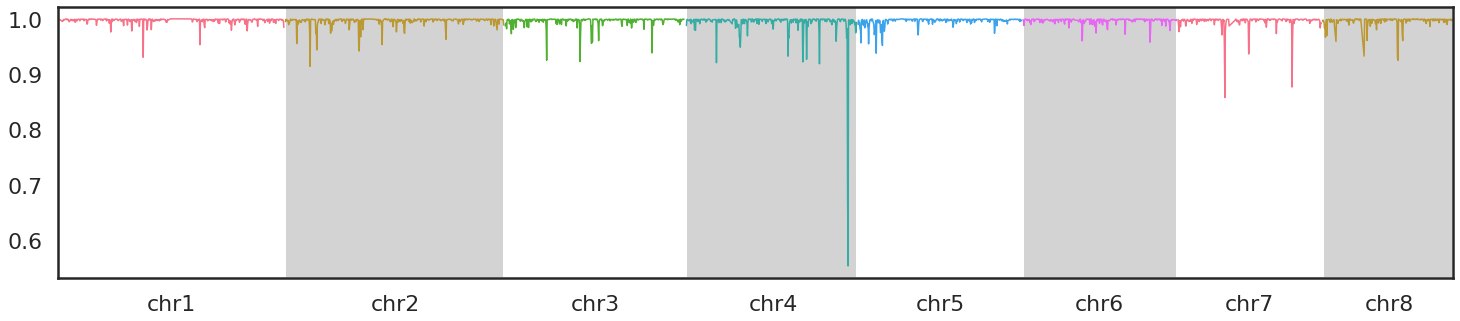

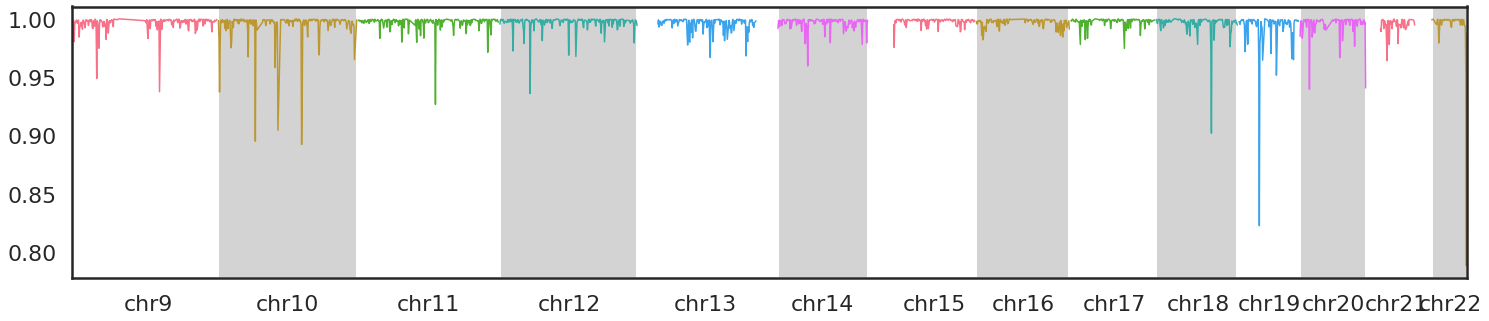

In [52]:
all_indivs_genomeplot(ref_spear)

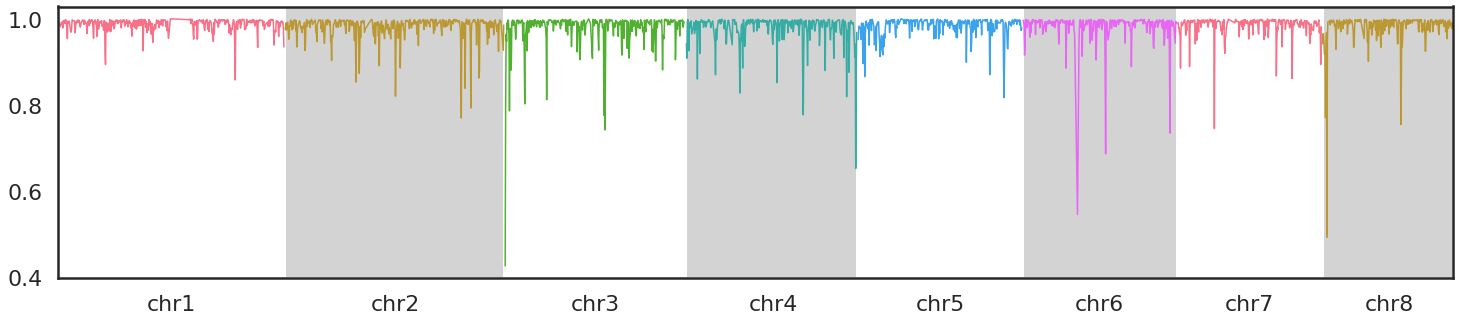

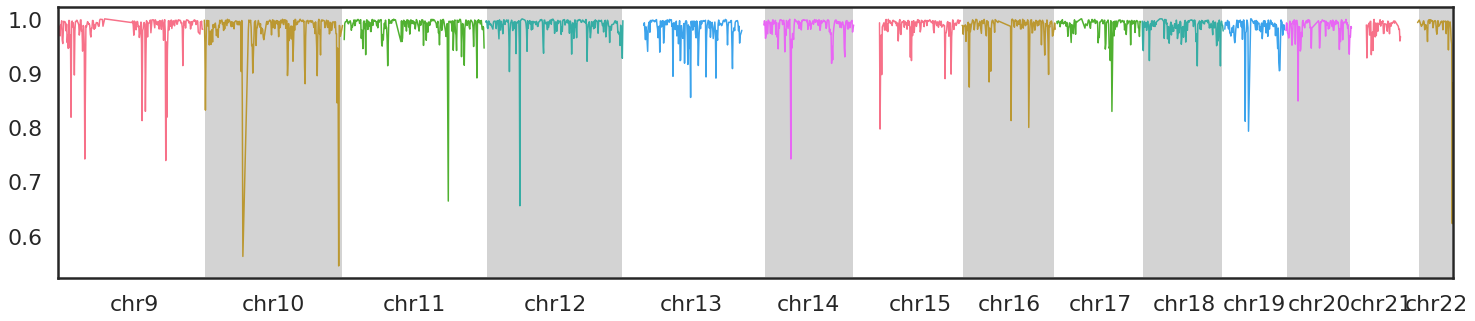

In [53]:
all_indivs_genomeplot(gagp_spear)

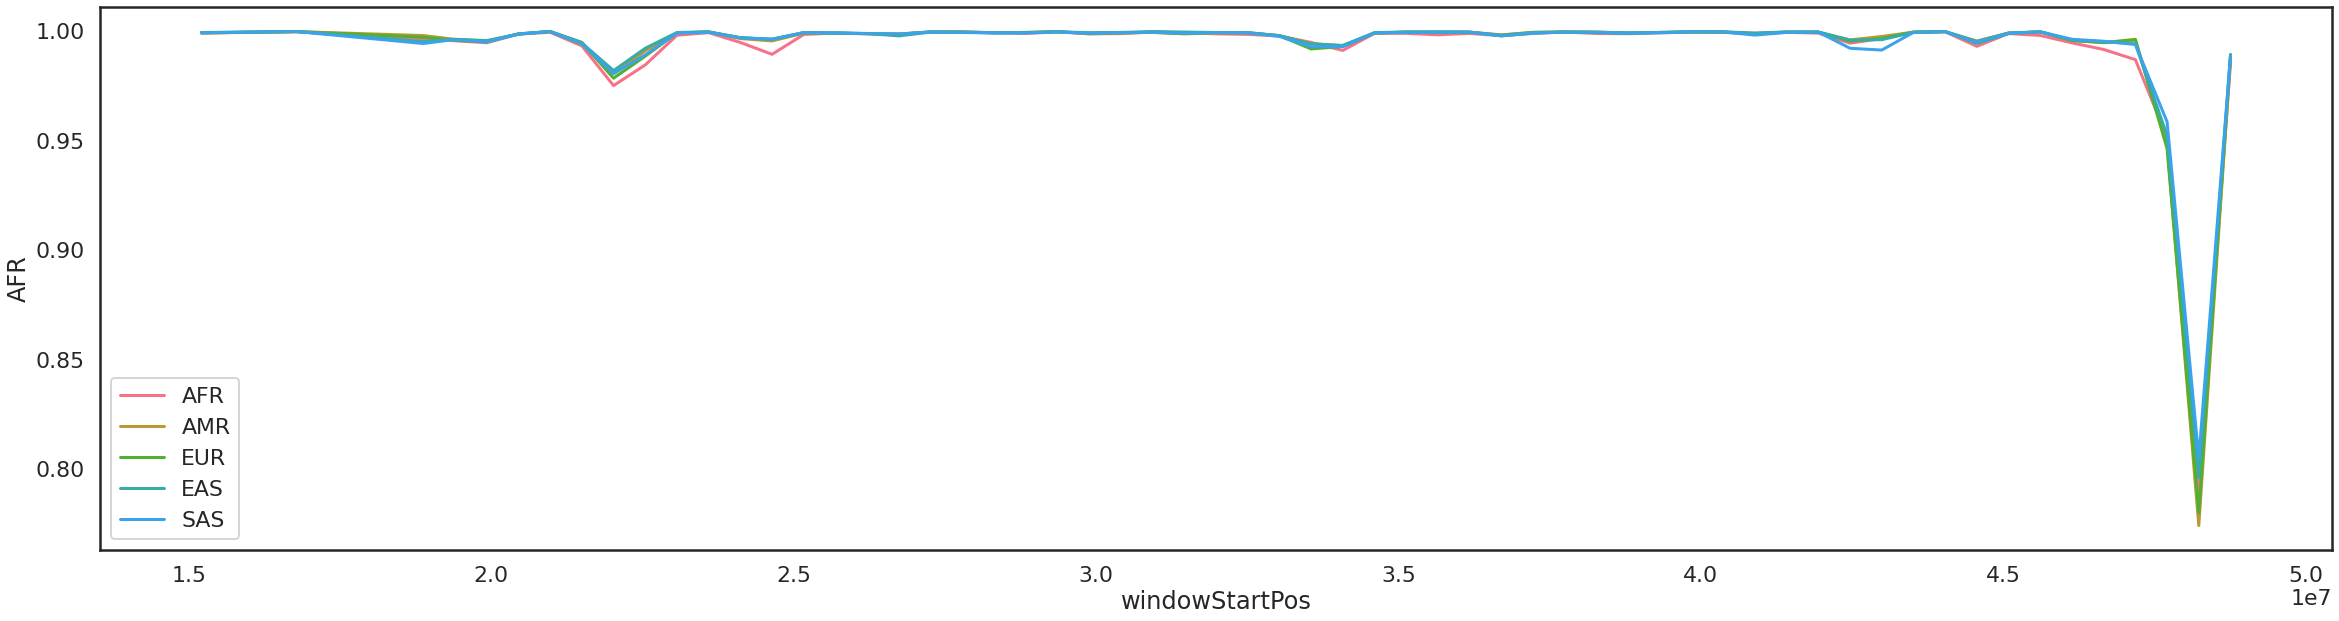

In [54]:
one_chrm_pop_plot(ref_spear, 'chr22')

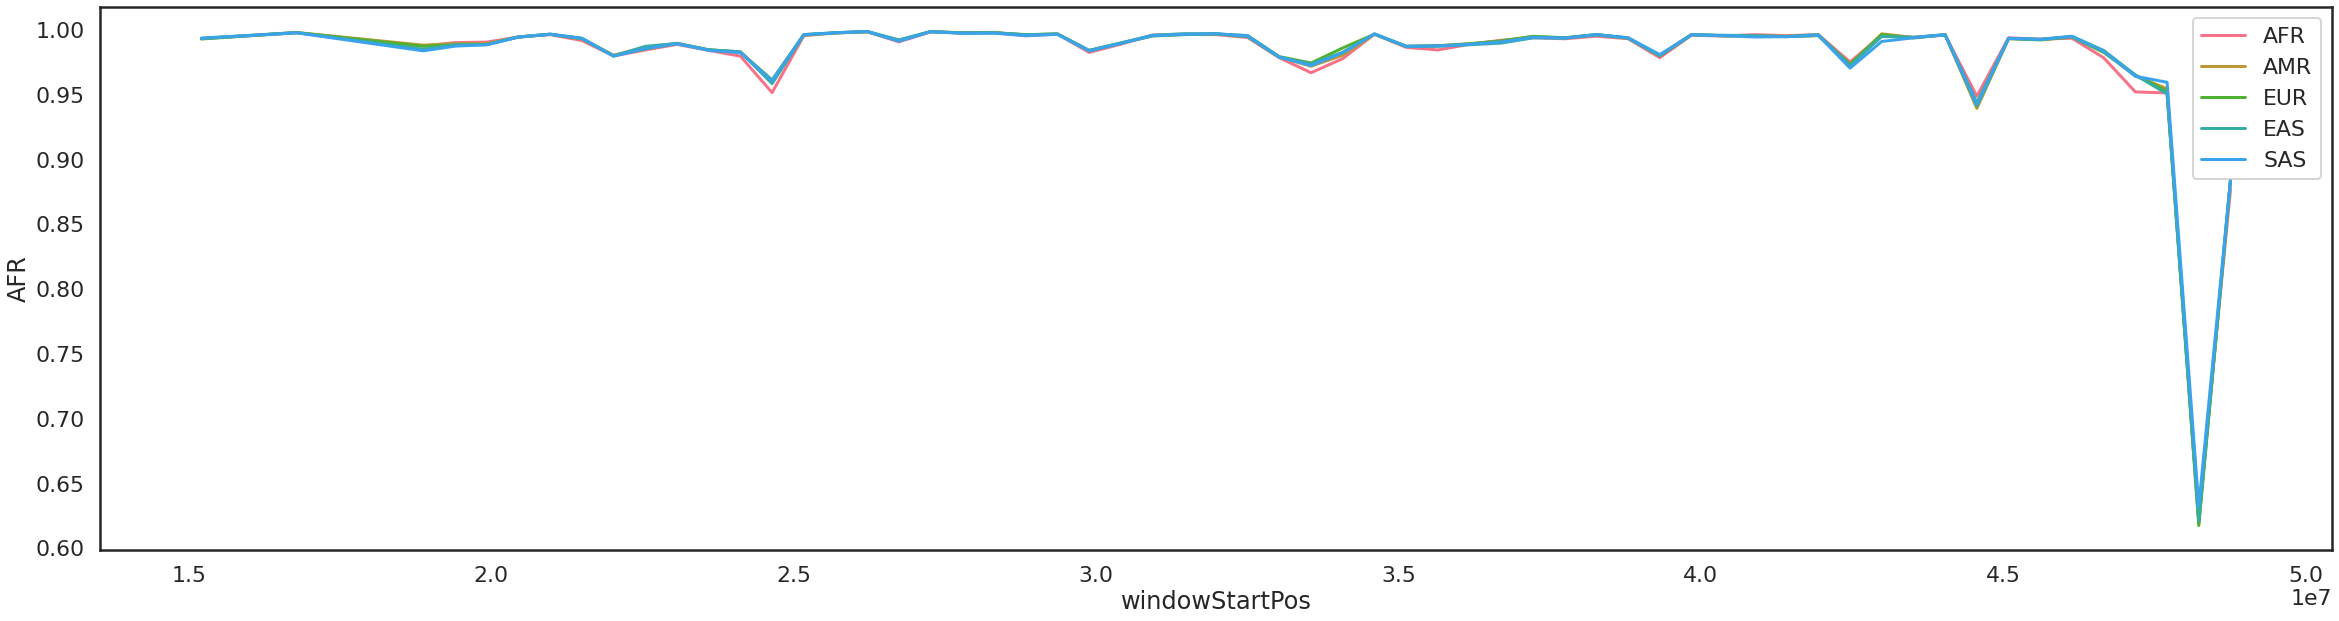

In [55]:
one_chrm_pop_plot(gagp_spear, 'chr22')

HARs and 3D genome?


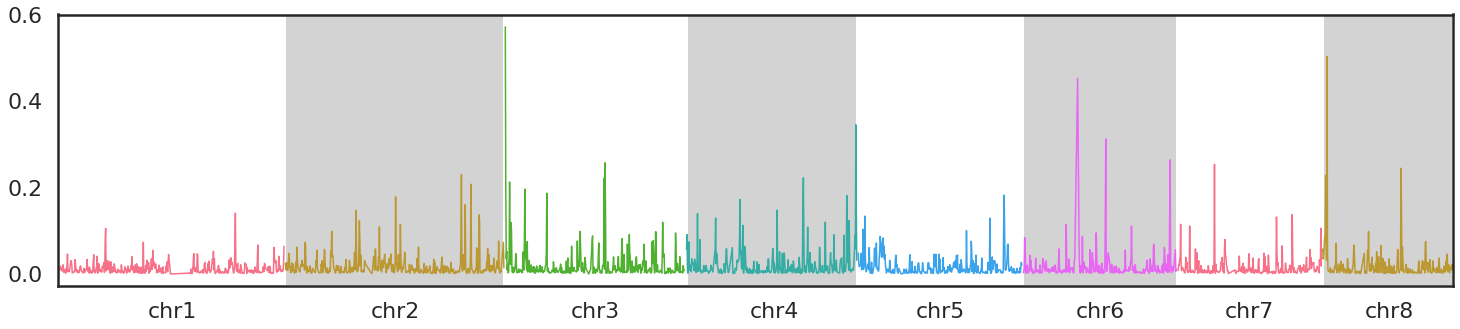

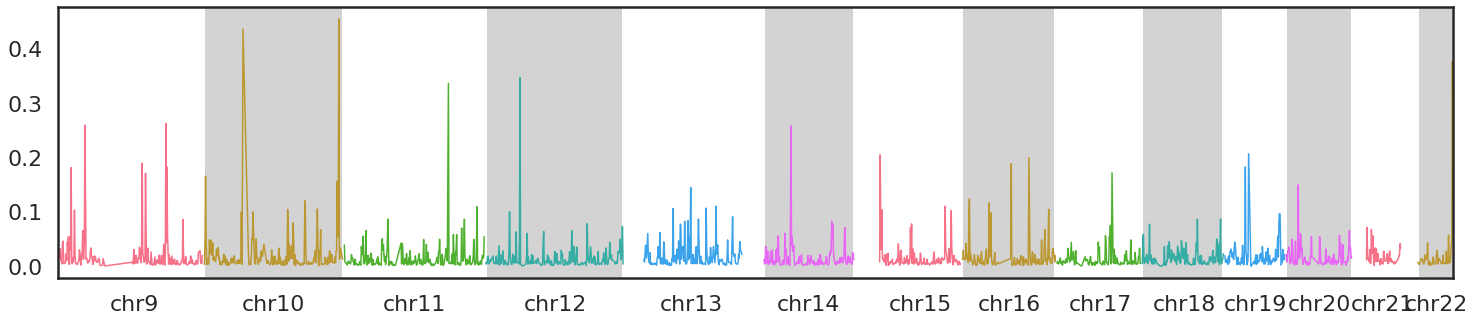

In [48]:
all_indivs_genomeplot(gagp_div)

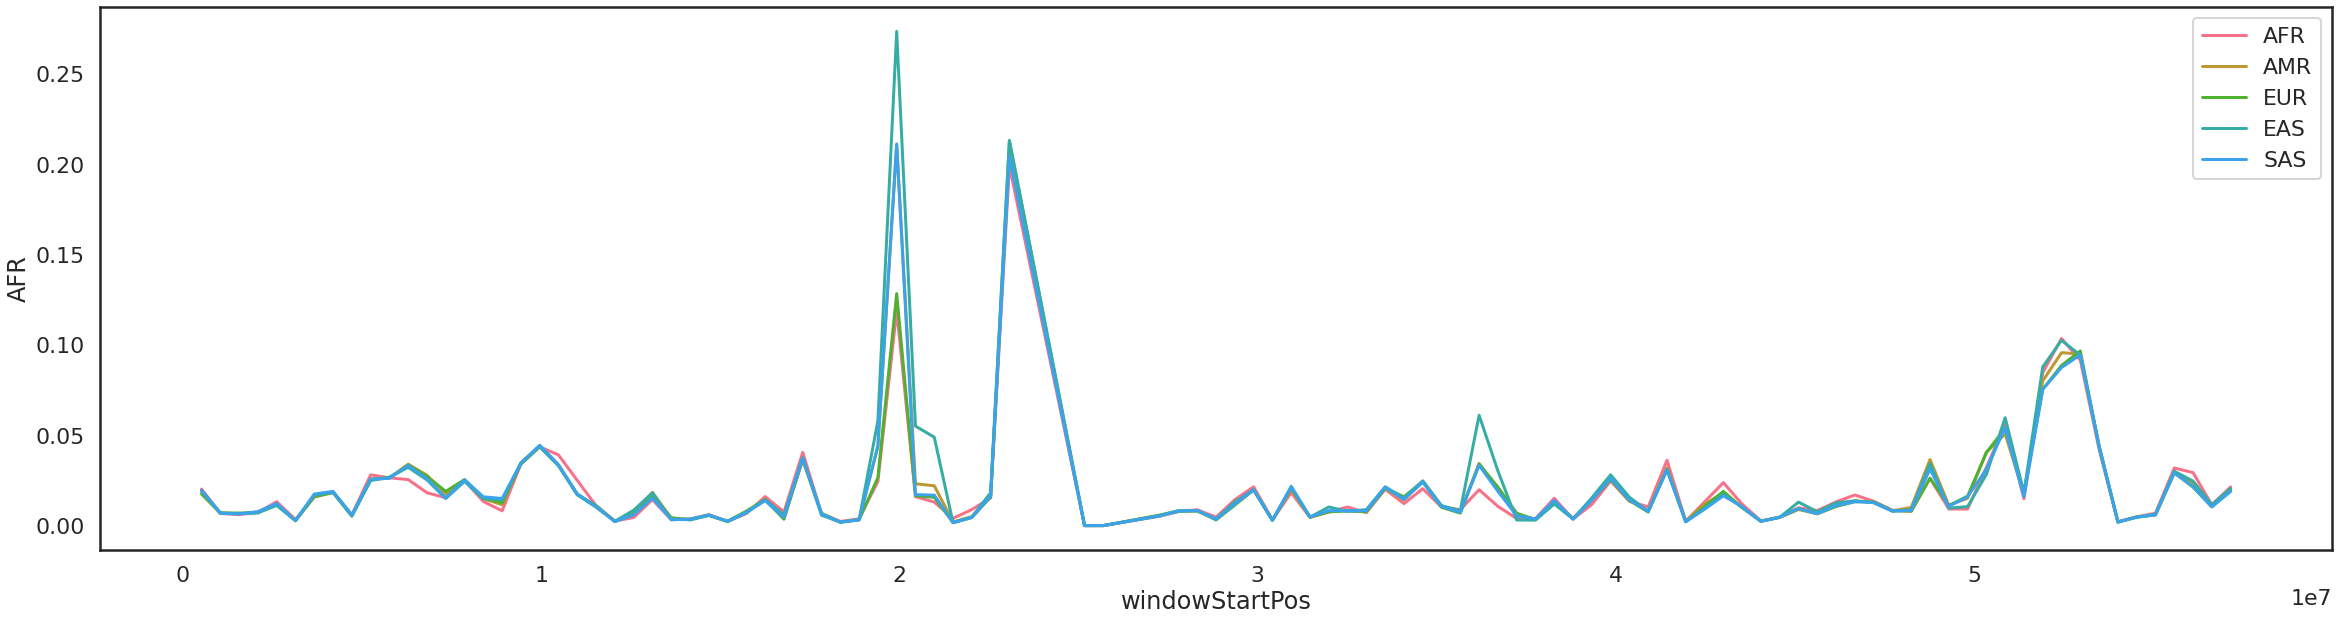

In [23]:
one_chrm_pop_plot(gagp_div, 'chr19')

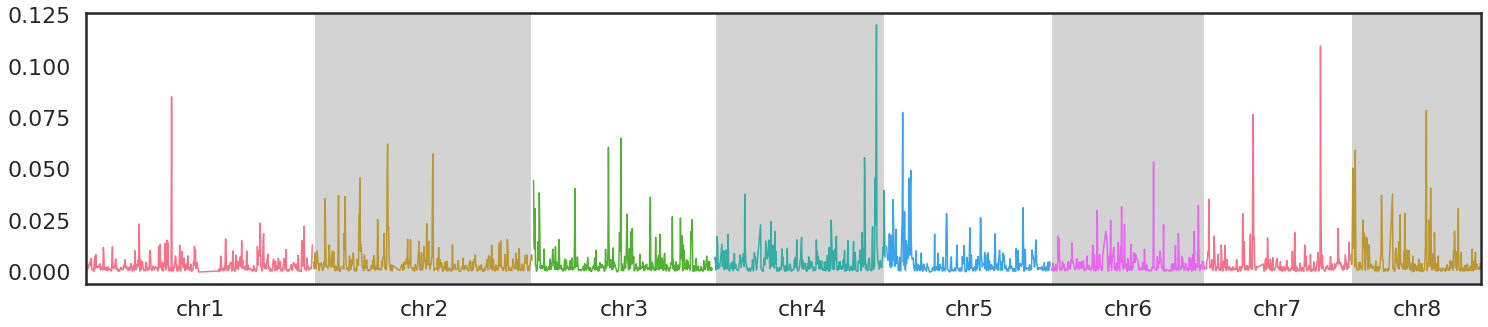

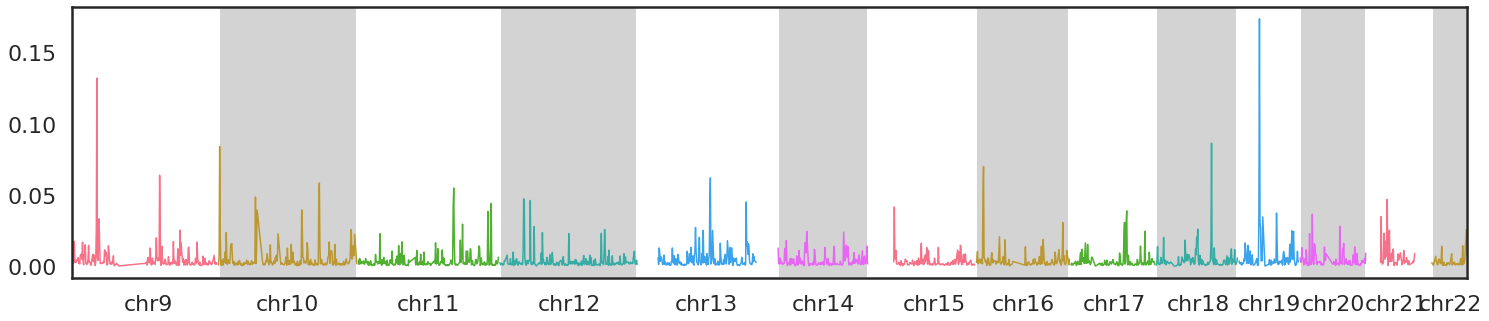

In [47]:
std_genomeplot(gagp_div)